**This project uses -Used_Cars- Dataset to predict their prices**

# **Importing Libraries & Dependencies**

In [ ]:
# Installing Dependencies
!pip install category_encoders
!pip install catboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
from pandas.core.dtypes.api import is_numeric_dtype , is_string_dtype
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , RobustScaler , OneHotEncoder , OrdinalEncoder , PolynomialFeatures , LabelEncoder , FunctionTransformer
from category_encoders import BinaryEncoder
from sklearn.model_selection import cross_validate , KFold , train_test_split , GridSearchCV , cross_val_score
from sklearn.feature_selection import SelectFromModel , SelectKBest , chi2
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor , AdaBoostRegressor , HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score , mean_squared_error
from optuna import create_study
import optuna
from google.colab import files
from optuna.integration import OptunaSearchCV

# Read & Explore Dataset

In [ ]:
# read data
df = pd.read_csv('/content/Cars.csv')
df

,Unnamed: 0,Brand,Model,Body,Color,Year,Fuel,Kilometers,Engine,Transmission,Price,Gov
0,5337,Hyundai,Accent,Sedan,Black,2007,Benzine,140000 to 159999,1600 CC,Automatic,140.0,Giza
1,5338,Hyundai,Accent,Sedan,Silver,2005,Benzine,180000 to 199999,1000 - 1300 CC,Manual,78.0,Qena
2,5339,Hyundai,Accent,Sedan,Gray,1999,Benzine,140000 to 159999,1400 - 1500 CC,Manual,70.0,Giza
3,5340,Hyundai,Accent,Sedan,Blue- Navy Blue,2009,Benzine,140000 to 159999,1600 CC,Automatic,150.0,Cairo
4,5341,Hyundai,Accent,Sedan,Silver,2000,Benzine,10000 to 19999,1000 - 1300 CC,Manual,75.0,Giza
...,...,...,...,...,...,...,...,...,...,...,...,...
14736,14209,Fiat,Uno,Hatchback,Burgundy,1997,Benzine,160000 to 179999,1000 - 1300 CC,Manual,46.0,Cairo
14737,14210,Fiat,Uno,Hatchback,Silver,1996,Benzine,20000 to 29999,1000 - 1300 CC,Manual,46.0,Alexandria
14738,14211,Fiat,Uno,Hatchback,Burgundy,1993,Benzine,10000 to 19999,1000 - 1300 CC,Manual,43.7,Giza
14739,14212,Fiat,Uno,Hatchback,Silver,1996,Benzine,10000 to 19999,1000 - 1300 CC,Manual,69.0,Cairo


In [ ]:
# make summary of dataframe :

def summary_data(dataframe) :

  summary = pd.DataFrame(dataframe.dtypes , columns=['Dtypes'])
  summary['Missing %'] = dataframe.isna().mean() * 100
  summary['Count'] = dataframe.count().values
  summary['Unique'] = dataframe.nunique().values


  return summary


summary_data(df).style.background_gradient(cmap='Blues')

,Dtypes,Missing %,Count,Unique
Unnamed: 0,int64,0.000000,14741,14741
Brand,object,0.000000,14741,3
Model,object,0.000000,14741,18
Body,object,0.000000,14741,3
Color,object,0.000000,14741,14
Year,int64,0.000000,14741,53
Fuel,object,0.000000,14741,2
Kilometers,object,0.000000,14741,16
Engine,object,0.000000,14741,3
Transmission,object,0.000000,14741,2


# EDA

In [ ]:

# plotting numrical features :

def plot_numerical(dataframe , color) :

  plt.figure(figsize=(25,25))
  idx = 0
  num_columns = dataframe.select_dtypes('number')
  for column in num_columns :
    plt.subplot(5,5,idx+1)
    sns.histplot(x = dataframe[column] , color = color , kde=True)
    plt.title(column)
    idx += 1
  plt.suptitle('Uni-Numerical Distribution', x=0.3, y=.95, horizontalalignment='left', verticalalignment='top', fontsize = 15)




#plot_numerical(df , 'skyblue')



In [ ]:
# plotting categorial features with uniques < 4 with piechart :


def plot_pie(dataframe ,row_count ,column_count ,colors) :

  cat_columns = dataframe.select_dtypes('object').columns
  pie_columns = []

  for col in cat_columns:

    if dataframe[col].nunique() < 4 :
      pie_columns.append(col)


  if len(pie_columns) > 0 :

    plt.figure(figsize=(12,12))
    idx = 0
    for column in pie_columns :
      col_values = dataframe[column].value_counts()
      plt.subplot(row_count,column_count,idx+1)
      plt.pie(col_values ,labels=col_values.index , autopct='%1.1f%%' , colors=colors , shadow=True)
      plt.title(column)
      idx +=1

    plt.tight_layout()
    plt.suptitle('Pie Distribution' , fontsize = 16)
    plt.show()

  else :

    return f'No Category columns to be represente4 in pie chart.'



#plot_pie(df ,row_count=2 , column_count=3, colors=['lightskyblue' , 'deepskyblue' ,'aqua' , 'mediumturquoise' ])



In [ ]:
# plotting categorial features with uniques >= 4 with countplot :


def plot_countplot(dataframe , row_count ,column_count , hue=None) :

  cat_columns = dataframe.select_dtypes('object').columns
  countplot_columns = []

  for col in cat_columns:

    if dataframe[col].nunique() >= 4 :
      countplot_columns.append(col)


  if len(countplot_columns) > 0 :

    plt.figure(figsize=(25,25))
    idx = 0
    sns.set(style='whitegrid' , color_codes=True)
    for column in countplot_columns :
      plt.subplot(row_count,column_count,idx+1)
      sns.countplot(data=dataframe ,y=column ,hue=hue , palette='Blues_d')
      plt.title(column , fontsize=13)
      idx +=1
    plt.suptitle('Countplot Distribution' , fontsize=33)

  else :

    return f'No Category columns to be represented in countplot.'



#plot_pie(df ,  row_count=2 , column_count=2)



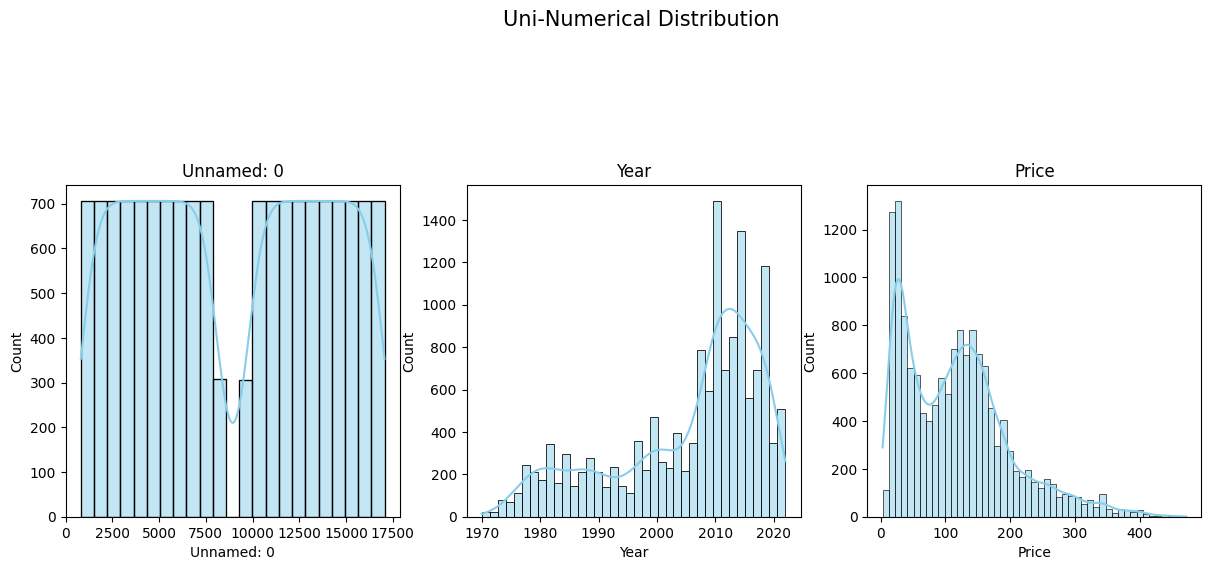

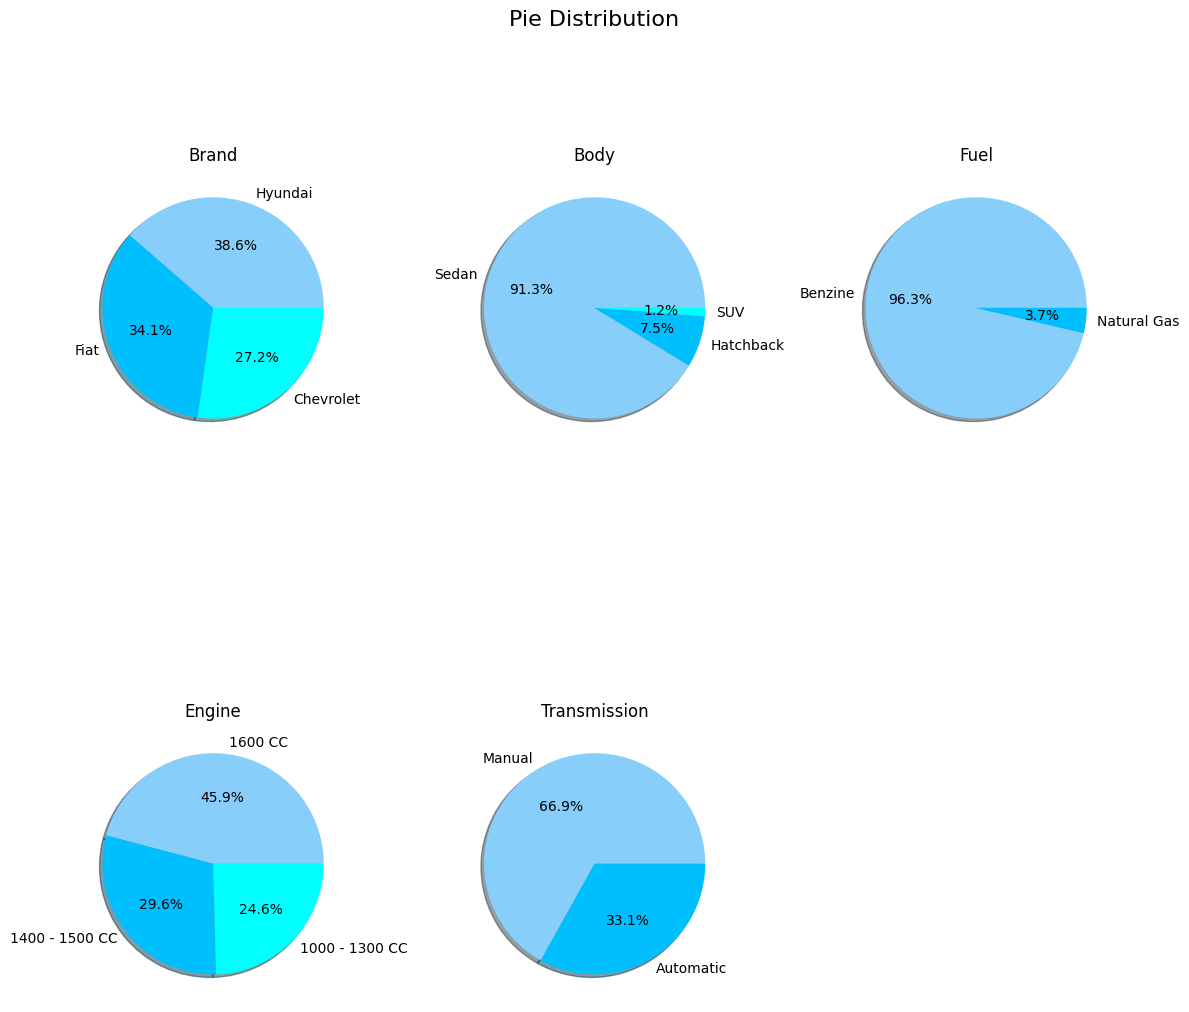

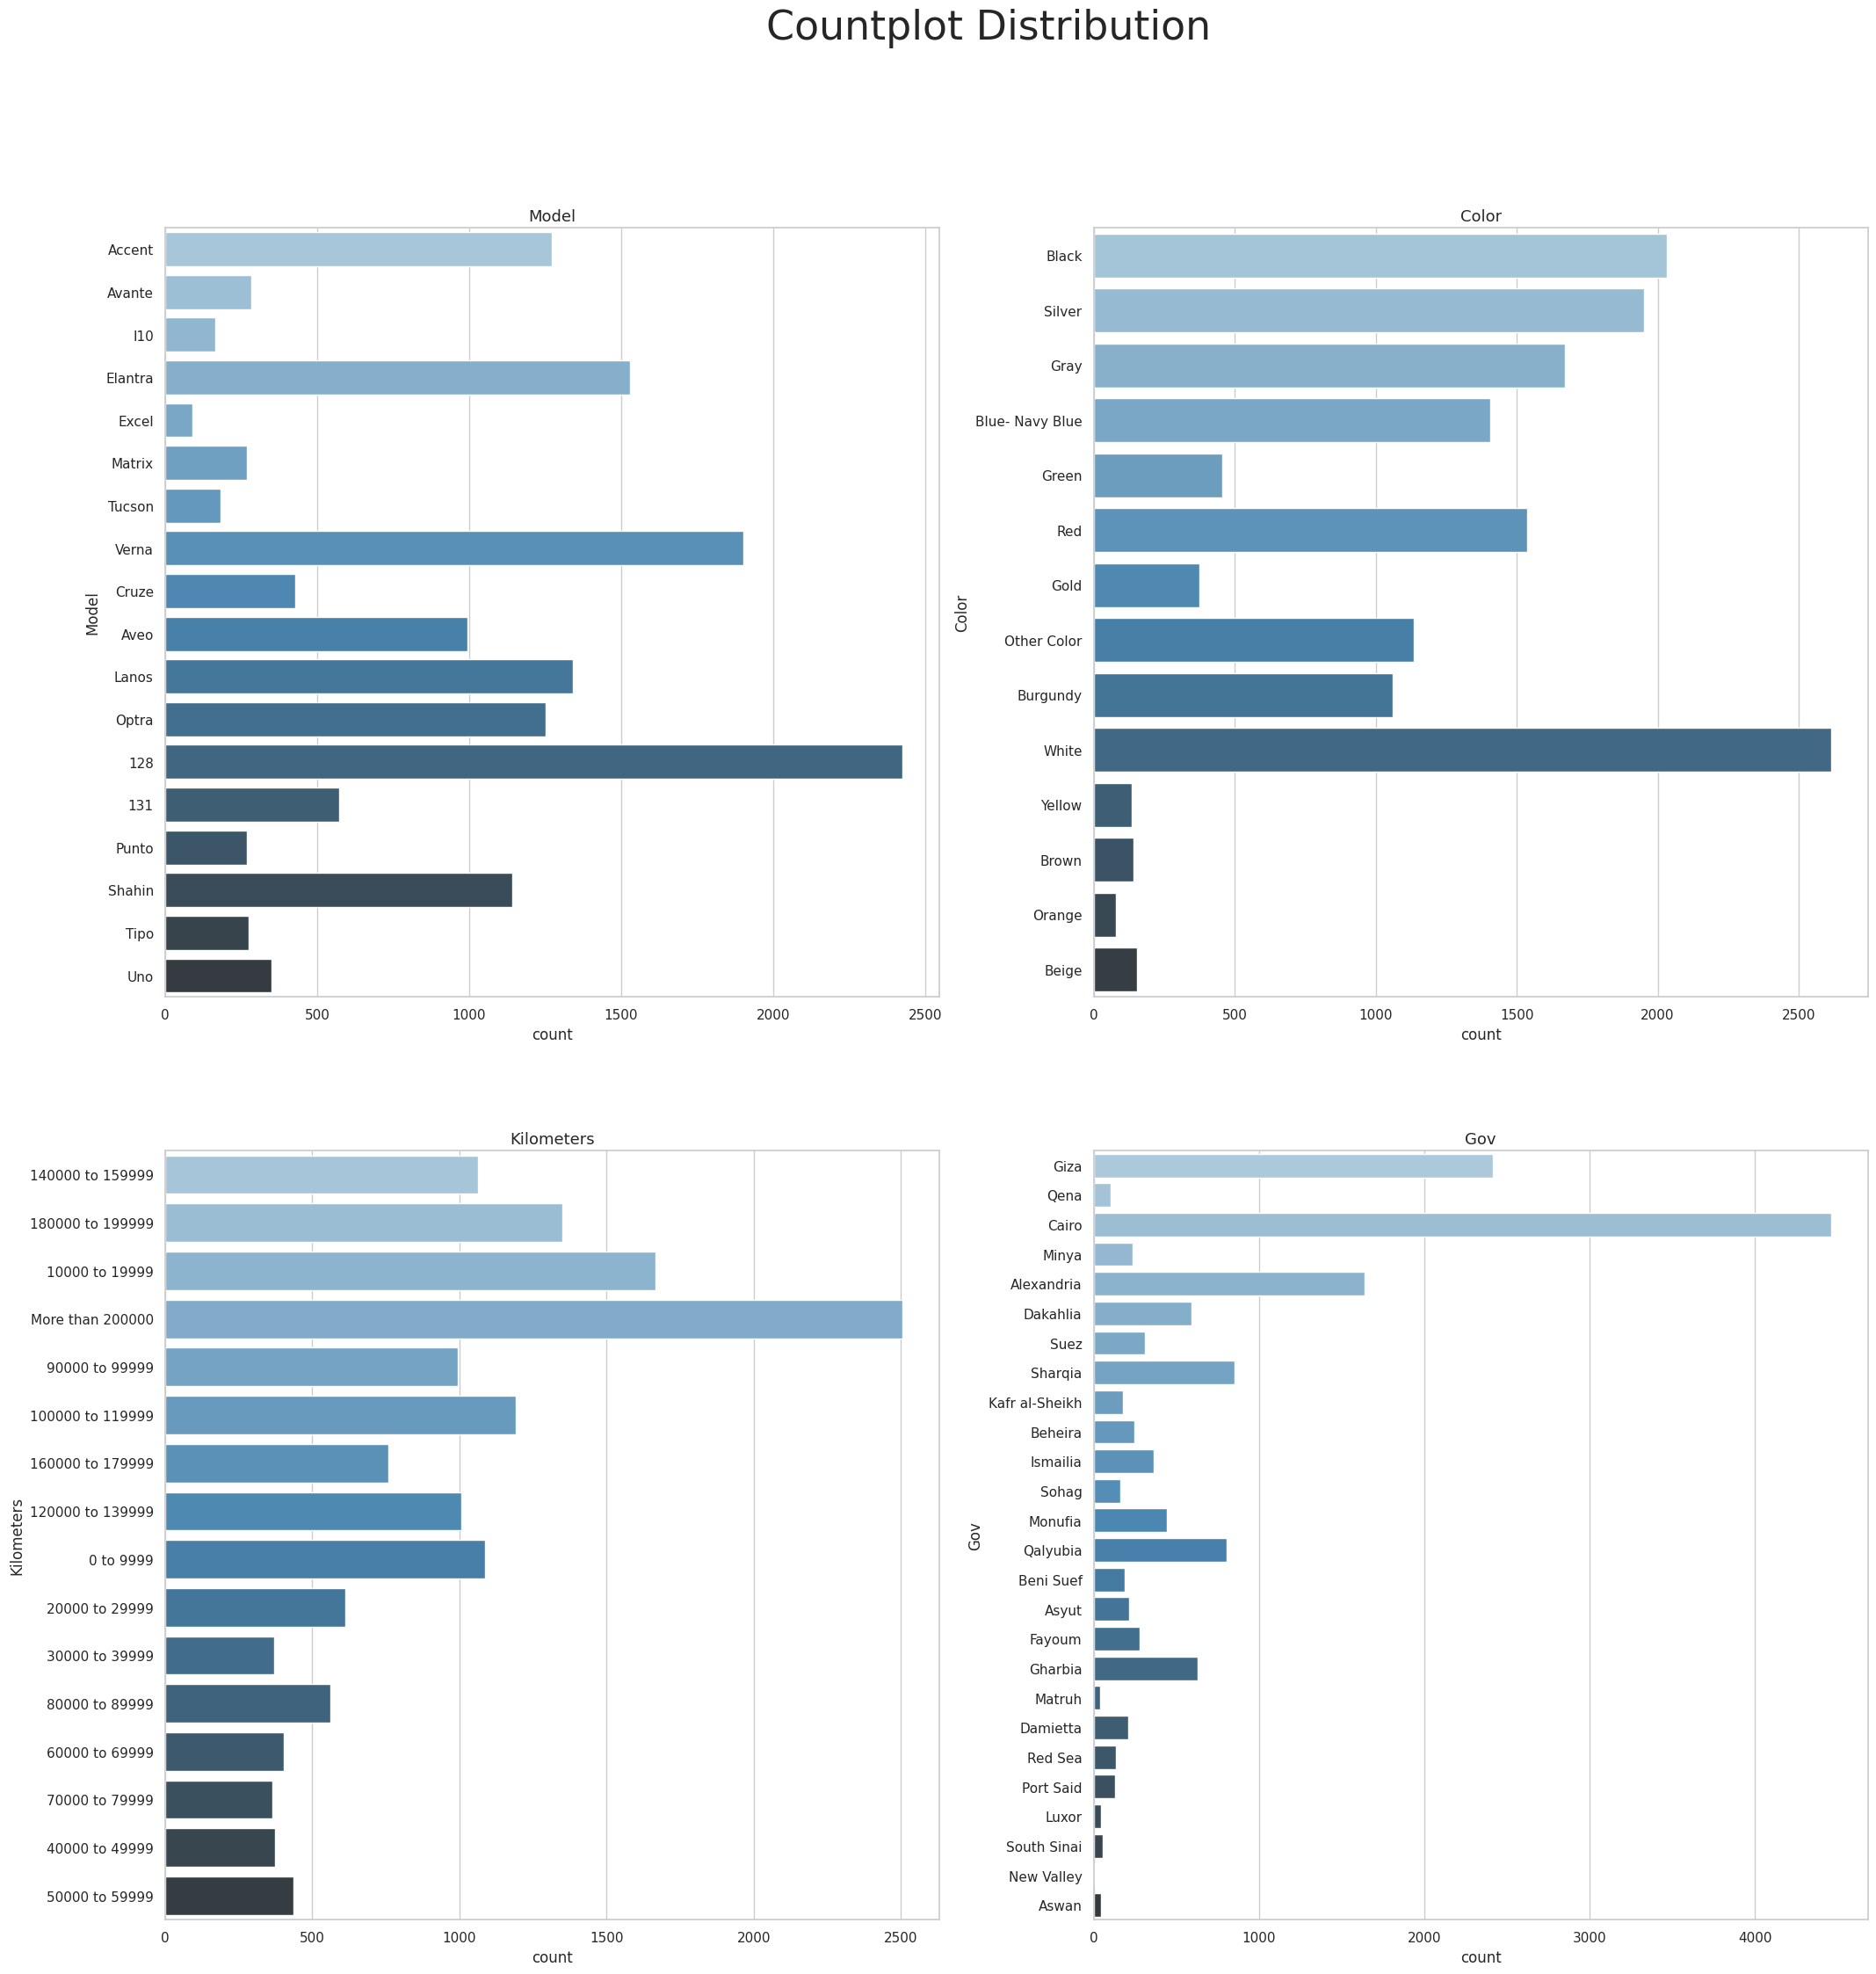

In [ ]:
plot_numerical(df , 'skyblue')
plot_pie(df ,row_count=2 , column_count=3, colors=['lightskyblue' , 'deepskyblue' ,'aqua' , 'mediumturquoise' ])
plot_countplot(df ,  row_count=2 , column_count=2)

# Preprocessing , Primary attemp

In [ ]:
# drop first column :
df.drop(df.columns[0] , axis=1 , inplace=True)

In [ ]:
df.columns

Index(['Brand', 'Model', 'Body', 'Color', 'Year', 'Fuel', 'Kilometers',
       'Engine', 'Transmission', 'Price', 'Gov'],
      dtype='object')

In [ ]:
df['Kilometers'].unique()

array(['140000 to 159999', '180000 to 199999', '10000 to 19999',
       'More than 200000', '90000 to 99999', '100000 to 119999',
       '160000 to 179999', '120000 to 139999', '0 to 9999',
       '20000 to 29999', '30000 to 39999', '80000 to 89999',
       '60000 to 69999', '70000 to 79999', '40000 to 49999',
       '50000 to 59999'], dtype=object)

In [ ]:
df

,Brand,Model,Body,Color,Year,Fuel,Kilometers,Engine,Transmission,Price,Gov
0,Hyundai,Accent,Sedan,Black,2007,Benzine,140000 to 159999,1600 CC,Automatic,140.0,Giza
1,Hyundai,Accent,Sedan,Silver,2005,Benzine,180000 to 199999,1000 - 1300 CC,Manual,78.0,Qena
2,Hyundai,Accent,Sedan,Gray,1999,Benzine,140000 to 159999,1400 - 1500 CC,Manual,70.0,Giza
3,Hyundai,Accent,Sedan,Blue- Navy Blue,2009,Benzine,140000 to 159999,1600 CC,Automatic,150.0,Cairo
4,Hyundai,Accent,Sedan,Silver,2000,Benzine,10000 to 19999,1000 - 1300 CC,Manual,75.0,Giza
...,...,...,...,...,...,...,...,...,...,...,...
14736,Fiat,Uno,Hatchback,Burgundy,1997,Benzine,160000 to 179999,1000 - 1300 CC,Manual,46.0,Cairo
14737,Fiat,Uno,Hatchback,Silver,1996,Benzine,20000 to 29999,1000 - 1300 CC,Manual,46.0,Alexandria
14738,Fiat,Uno,Hatchback,Burgundy,1993,Benzine,10000 to 19999,1000 - 1300 CC,Manual,43.7,Giza
14739,Fiat,Uno,Hatchback,Silver,1996,Benzine,10000 to 19999,1000 - 1300 CC,Manual,69.0,Cairo


In [ ]:
ohe = OneHotEncoder(sparse_output=False , drop='first')
ohe_df = pd.DataFrame(ohe.fit_transform(df[df.select_dtypes('object').columns]) , columns=ohe.get_feature_names_out())
df = pd.concat([df,ohe_df] , axis=1)
df.drop(df.select_dtypes('object').columns , axis=1 , inplace=True)

In [ ]:
df['Car_Age'] = 2023 - df['Year']
df.drop('Year' , axis=1 , inplace=True)

In [ ]:
df.shape

(14741, 80)

In [ ]:
X , y = df.drop('Price' , axis=1) , df['Price']

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state=0)

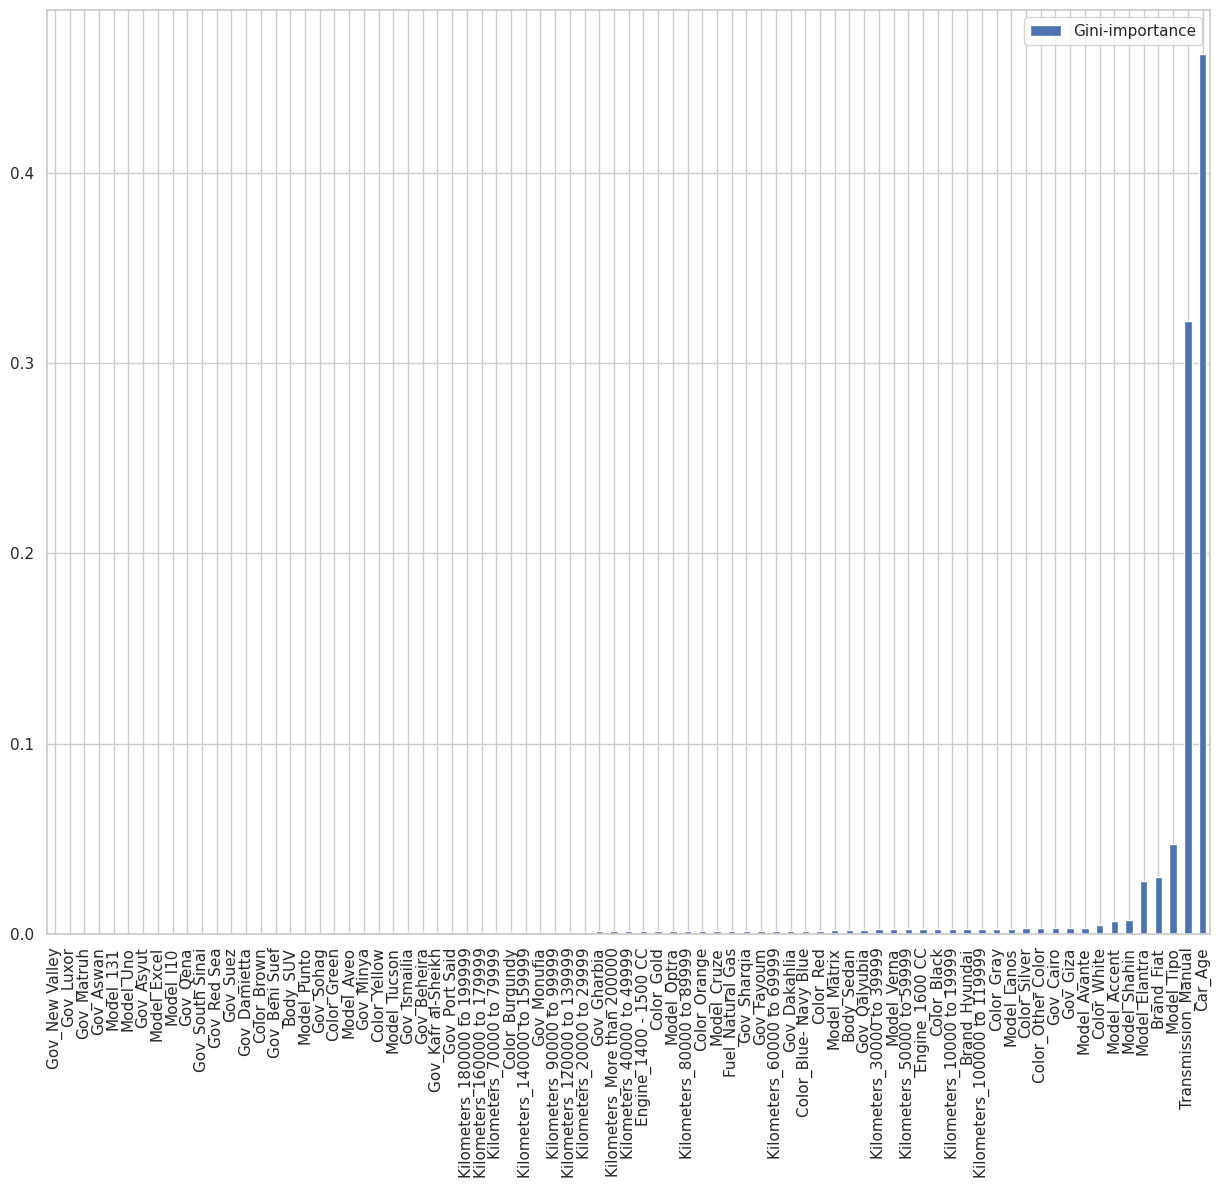

In [ ]:
feature_names = [f'feature {i}' for i in range((X.shape[1]))]
forest = RandomForestRegressor (random_state=42)
forest.fit (x_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
  feats[feature] = importance #add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values (by='Gini-importance').plot(kind='bar', rot=90, figsize= (15,12))
plt.show()

<ipython-input-19-c564c922771d>:7: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,65,1)


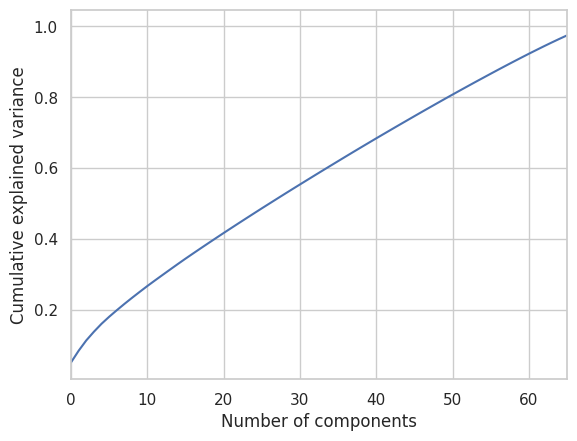

In [ ]:
X_Train=x_train.values
X_Train=np.asarray(X_Train)
# Finding normalised array of X_Train
x_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(x_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,65,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
x_train.shape

(11792, 79)

In [ ]:
sclr = StandardScaler()
x_train[x_train.columns] = sclr.fit_transform(x_train[x_train.columns])
x_test[x_test.columns] = sclr.transform(x_test[x_test.columns])

In [ ]:
x_train

,Brand_Fiat,Brand_Hyundai,Model_131,Model_Accent,Model_Avante,Model_Aveo,Model_Cruze,Model_Elantra,Model_Excel,Model_I10,...,Gov_New Valley,Gov_Port Said,Gov_Qalyubia,Gov_Qena,Gov_Red Sea,Gov_Sharqia,Gov_Sohag,Gov_South Sinai,Gov_Suez,Car_Age
3420,-0.717296,1.254412,-0.198957,3.247993,-0.142907,-0.265960,-0.173087,-0.342184,-0.076719,-0.109217,...,-0.022563,-0.092482,-0.23837,-0.084194,-0.096143,-0.247762,-0.108018,-0.061199,-0.147173,-0.753894
6882,-0.717296,-0.797186,-0.198957,-0.307882,-0.142907,-0.265960,-0.173087,-0.342184,-0.076719,-0.109217,...,-0.022563,-0.092482,-0.23837,-0.084194,-0.096143,-0.247762,-0.108018,-0.061199,-0.147173,-0.674757
6204,-0.717296,-0.797186,-0.198957,-0.307882,-0.142907,3.759967,-0.173087,-0.342184,-0.076719,-0.109217,...,-0.022563,-0.092482,-0.23837,-0.084194,-0.096143,4.036127,-0.108018,-0.061199,-0.147173,-0.279073
11084,1.394125,-0.797186,5.026212,-0.307882,-0.142907,-0.265960,-0.173087,-0.342184,-0.076719,-0.109217,...,-0.022563,-0.092482,-0.23837,-0.084194,-0.096143,-0.247762,-0.108018,-0.061199,-0.147173,1.778485
6441,-0.717296,-0.797186,-0.198957,-0.307882,-0.142907,-0.265960,-0.173087,-0.342184,-0.076719,-0.109217,...,-0.022563,-0.092482,-0.23837,-0.084194,-0.096143,-0.247762,-0.108018,-0.061199,-0.147173,-0.595620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,1.394125,-0.797186,-0.198957,-0.307882,-0.142907,-0.265960,-0.173087,-0.342184,-0.076719,-0.109217,...,-0.022563,-0.092482,-0.23837,-0.084194,-0.096143,-0.247762,-0.108018,-0.061199,-0.147173,1.145390
3264,-0.717296,1.254412,-0.198957,3.247993,-0.142907,-0.265960,-0.173087,-0.342184,-0.076719,-0.109217,...,-0.022563,-0.092482,-0.23837,-0.084194,-0.096143,-0.247762,-0.108018,-0.061199,-0.147173,-0.912168
9845,1.394125,-0.797186,-0.198957,-0.307882,-0.142907,-0.265960,-0.173087,-0.342184,-0.076719,-0.109217,...,-0.022563,-0.092482,-0.23837,-0.084194,-0.096143,4.036127,-0.108018,-0.061199,-0.147173,1.620212
10799,1.394125,-0.797186,-0.198957,-0.307882,-0.142907,-0.265960,-0.173087,-0.342184,-0.076719,-0.109217,...,-0.022563,-0.092482,-0.23837,-0.084194,-0.096143,-0.247762,-0.108018,-0.061199,-0.147173,1.145390


In [ ]:

models = {
    'LinearRegression' : LinearRegression() ,
    'KNN' : KNeighborsRegressor(),
    'DecisionTree' : DecisionTreeRegressor(),
    'RandomForest' : RandomForestRegressor(max_depth=10),
    'XGB' : XGBRegressor(),
    'AdaBoost' : AdaBoostRegressor(),
    'LGBM' : LGBMRegressor(),
  #  'CatBoost' : CatBoostRegressor()
}


data = {

        'full_dataset' : X.columns ,
        '40_features' : importances.sort_values(by='Gini-importance')[-40:].index.tolist() ,
        '20_features' : importances.sort_values(by='Gini-importance')[-20:].index.tolist() ,
        '10_features' : importances.sort_values(by='Gini-importance')[-10:].index.tolist()
}

In [ ]:
for feature_names , feature in data.items():
  train_score = []
  test_score = []
  Regressor = []
  for model_name , model in models.items() :
    #print(f'training with {feature_names}')
    scores = cross_validate(estimator=model , X=X[feature], y=y , cv=KFold(n_splits=5),scoring='r2',return_train_score=True)
    #print(f'Train r2 score is : {r2_score(y_train , train)}')
    #print(f'Test r2 score is : {r2_score(y_test , test)}')
    Regressor.append(model_name)
    train_score.append(scores['train_score'].mean())
    test_score.append(scores['test_score'].mean())
  print(f'training with {feature_names} results: ')

  #print(Regressor)
  #print(train_score)
  #print(test_score)
  final = pd.DataFrame({
      'Model' : Regressor ,
      'r2_train' : train_score ,
      'r2_test' : test_score
    })

  display(final)
  print('*' * 50)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 78
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 78
[LightGBM] [Info] Start training from score 104.506546
[LightGBM] [Warning]

,Model,r2_train,r2_test
0,LinearRegression,0.852134,0.712302
1,KNN,0.934184,0.786196
2,DecisionTree,0.987552,0.745885
3,RandomForest,0.937256,0.789065
4,XGB,0.960877,0.811836
5,AdaBoost,0.802796,0.558947
6,LGBM,0.930153,0.803387


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 40
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 40
[LightGBM] [Info] Start 

,Model,r2_train,r2_test
0,LinearRegression,0.847036,0.709940
1,KNN,0.934943,0.781451
2,DecisionTree,0.976344,0.747232
3,RandomForest,0.935286,0.783861
4,XGB,0.954762,0.792033
5,AdaBoost,0.797966,0.544978
6,LGBM,0.927716,0.793095


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 20
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 20
[LightGBM] [Info] Start tr

,Model,r2_train,r2_test
0,LinearRegression,0.836378,0.683787
1,KNN,0.916445,0.753927
2,DecisionTree,0.946989,0.721857
3,RandomForest,0.922111,0.777392
4,XGB,0.932114,0.779255
5,AdaBoost,0.805639,0.607740
6,LGBM,0.915269,0.789450


**************************************************
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 10
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 10
[LightGBM] [Info] Start training from score 104.506546
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_w

,Model,r2_train,r2_test
0,LinearRegression,0.829156,0.673877
1,KNN,0.856265,0.672424
2,DecisionTree,0.900645,0.728891
3,RandomForest,0.899711,0.748749
4,XGB,0.900261,0.736416
5,AdaBoost,0.804140,0.595878
6,LGBM,0.896716,0.761297


**************************************************


# 2nd Attemp , Changing encoding

In [ ]:
df = pd.read_csv('/content/Cars.csv')

In [ ]:
df.drop(df.columns[0] , axis=1 , inplace=True)

In [ ]:
# Ordinal Encoder for Kilometers & one hot encoder for rest

kilo_map = {

        '0 to 9999' : 0 ,
        '10000 to 19999' : 1,
        '20000 to 29999' : 2 ,
        '30000 to 39999' : 3 ,
        '40000 to 49999' : 4 ,
        '50000 to 59999' : 5 ,
        '60000 to 69999' : 6 ,
        '70000 to 79999' : 7 ,
        '80000 to 89999' : 8 ,
        '90000 to 99999' : 9 ,
        '100000 to 119999' : 10 ,
        '120000 to 139999' : 11 ,
        '140000 to 159999' : 12 ,
        '160000 to 179999' : 13 ,
        '180000 to 199999' : 14 ,
        'More than 200000' : 15
}


df['Kilometers'] = df['Kilometers'].map(kilo_map)

In [ ]:
df['Car_Age'] = 2023 - df['Year']
df.drop('Year' , axis=1 , inplace=True)

In [ ]:
# encoding in different approach:
summary_data(df)

,Dtypes,Missing %,Count,Unique
Brand,object,0.0,14741,3
Model,object,0.0,14741,18
Body,object,0.0,14741,3
Color,object,0.0,14741,14
Fuel,object,0.0,14741,2
Kilometers,int64,0.0,14741,16
Engine,object,0.0,14741,3
Transmission,object,0.0,14741,2
Price,float64,0.0,14741,631
Gov,object,0.0,14741,26


In [ ]:
be = BinaryEncoder()
be_df = be.fit_transform(df[['Model' , 'Color' , 'Gov']])

In [ ]:
ohe = OneHotEncoder(sparse_output = False , drop='first')
ohe_df = pd.DataFrame(ohe.fit_transform(df[['Brand' , 'Body' , 'Fuel' , 'Engine' , 'Transmission']]) , columns=ohe.get_feature_names_out())
df = pd.concat([df,ohe_df , be_df] , axis=1)
df.drop(['Brand' , 'Body' , 'Fuel' , 'Engine' , 'Transmission' , 'Model' , 'Color' , 'Gov'] , axis=1 , inplace=True)

In [ ]:
df

,Kilometers,Price,Car_Age,Brand_Fiat,Brand_Hyundai,Body_SUV,Body_Sedan,Fuel_Natural Gas,Engine_1400 - 1500 CC,Engine_1600 CC,...,Model_4,Color_0,Color_1,Color_2,Color_3,Gov_0,Gov_1,Gov_2,Gov_3,Gov_4
0,12,140.0,16,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1,0,0,0,1,0,0,0,0,1
1,14,78.0,18,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,1,0
2,12,70.0,24,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1,0,0,1,1,0,0,0,0,1
3,12,150.0,14,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1,0,1,0,0,0,0,0,1,1
4,1,75.0,23,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14736,13,46.0,26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,1,1
14737,2,46.0,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,1
14738,1,43.7,30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,1
14739,1,69.0,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,1


In [ ]:
X , y = df.drop('Price' , axis=1) , df['Price']

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state=0)

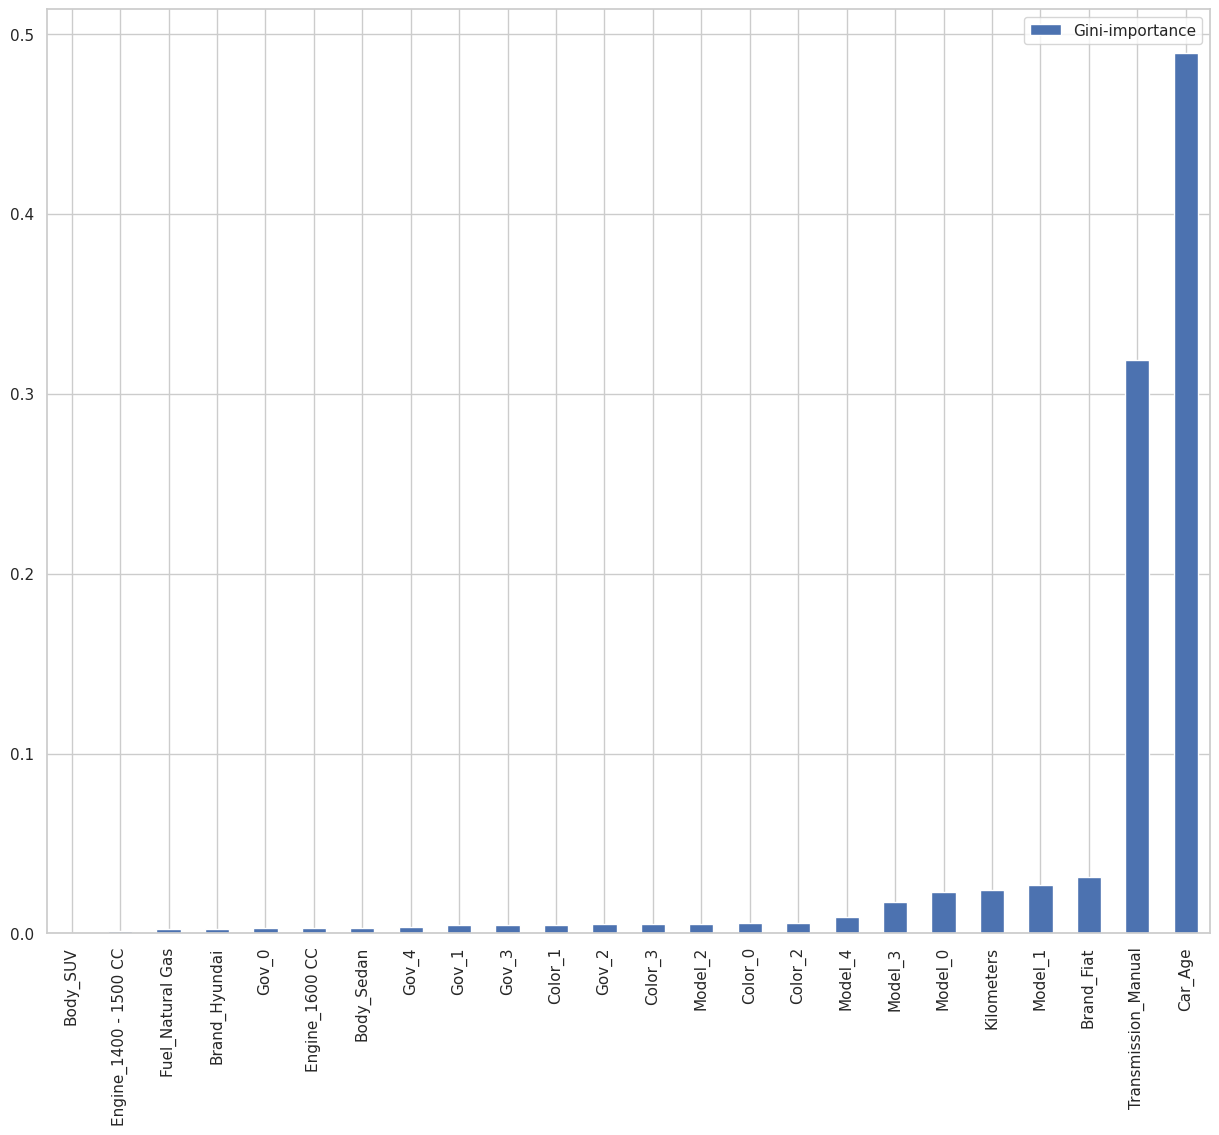

In [ ]:
feature_names = [f'feature {i}' for i in range((X.shape[1]))]
forest = RandomForestRegressor (random_state=42)
forest.fit (x_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
  feats[feature] = importance #add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values (by='Gini-importance').plot(kind='bar', rot=90, figsize= (15,12))
plt.show()

<ipython-input-36-017f45fd7e68>:7: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,24,1)


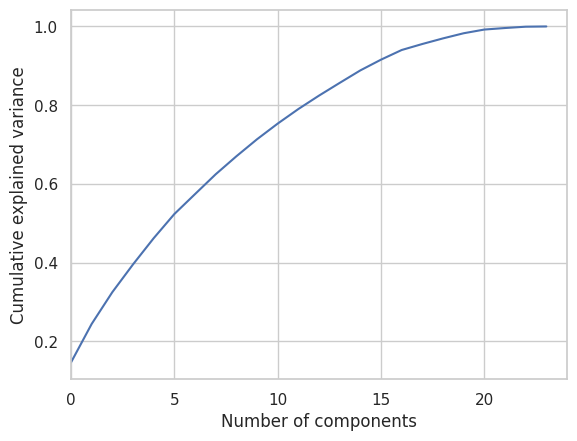

In [ ]:
X_Train=x_train.values
X_Train=np.asarray(X_Train)
# Finding normalised array of X_Train
x_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(x_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,24,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
sclr = StandardScaler()
x_train[x_train.columns] = sclr.fit_transform(x_train[x_train.columns])
x_test[x_test.columns] = sclr.transform(x_test[x_test.columns])

In [ ]:

models = {
    'LinearRegression' : LinearRegression() ,
    'KNN' : KNeighborsRegressor(),
    'DecisionTree' : DecisionTreeRegressor(),
    'RandomForest' : RandomForestRegressor(max_depth=10),
    'XGB' : XGBRegressor(),
    'AdaBoost' : AdaBoostRegressor(),
    'LGBM' : LGBMRegressor(),
   # 'CatBoost' : CatBoostRegressor()
}


data = {

        'full_dataset' : X.columns ,
        '40_features' : importances.sort_values(by='Gini-importance')[-40:].index.tolist() ,
        '20_features' : importances.sort_values(by='Gini-importance')[-20:].index.tolist() ,
        '10_features' : importances.sort_values(by='Gini-importance')[-10:].index.tolist()
}

In [ ]:
for feature_names , feature in data.items():
  train_r2 = []
  test_r2 = []
  Regressor = []
  train_rmse =[]
  test_rmse=[]
  train_mse = []
  test_mse = []
  train_mae = []
  test_mae = []
  for model_name , model in models.items() :
    #print(f'training with {feature_names}')
    scores = cross_validate(estimator=model , X=X[feature], y=y , cv=KFold(n_splits=5),scoring=['neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error' , 'r2'],return_train_score=True)
    #print(f'Train r2 score is : {r2_score(y_train , train)}')
    #print(f'Test r2 score is : {r2_score(y_test , test)}')
    #print(scores)
    Regressor.append(model_name)
    train_mae.append(scores['train_neg_mean_absolute_error'].mean() * -1)
    test_mae.append(scores['test_neg_mean_absolute_error'].mean() * -1)
    train_mse.append(scores['train_neg_mean_squared_error'].mean() * -1)
    test_mse.append(scores['test_neg_mean_squared_error'].mean() * -1)
    train_rmse.append(scores['train_neg_root_mean_squared_error'].mean() * -1)
    test_rmse.append(scores['test_neg_root_mean_squared_error'].mean() * -1)
    train_r2.append(scores['train_r2'].mean())
    test_r2.append(scores['test_r2'].mean())
  print(f'training with {feature_names} results: ')

  #print(Regressor)
  #print(train_score)
  #print(test_score)
  final = pd.DataFrame({
      'Model' : Regressor ,
      'mae_train' : train_mae ,
      'mae_test' : test_mae ,
      'mse_train' : train_mse ,
      'mse_test' : test_mse,
      'rmse_train' : train_rmse ,
      'rmse_test' : test_rmse,
      'train_r2' : train_r2,
      'test_r2' : test_r2
    })

  display(final)
  print('*' * 50)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 24
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 24
[LightGBM] [Info] Start training from score 104.506546
[LightGBM] [Warning]

,Model,mae_train,mae_test,mse_train,mse_test,rmse_train,rmse_test,train_r2,test_r2
0,LinearRegression,25.595478,32.453704,1323.602894,2121.240985,36.342048,45.148315,0.800158,0.537001
1,KNN,12.771018,19.544664,463.969287,1010.714915,21.488860,30.753274,0.929307,0.773953
2,DecisionTree,2.930882,19.985470,81.694433,1010.513685,8.971399,30.665615,0.987552,0.775741
3,RandomForest,11.854649,17.397861,423.044215,917.651859,20.432691,29.002670,0.935688,0.809732
4,XGB,10.002526,16.298024,269.001882,784.809273,16.334429,26.867785,0.958922,0.834304
5,AdaBoost,22.801681,27.082548,1164.853197,1680.625021,34.034180,38.979505,0.822678,0.653270
6,LGBM,12.293211,16.639775,436.899749,819.144127,20.813472,27.484383,0.933340,0.827721


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 24
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 24
[LightGBM] [Info] Start 

,Model,mae_train,mae_test,mse_train,mse_test,rmse_train,rmse_test,train_r2,test_r2
0,LinearRegression,25.595478,32.453704,1323.602894,2121.240985,36.342048,45.148315,0.800158,0.537001
1,KNN,12.771018,19.544664,463.969287,1010.714915,21.488860,30.753274,0.929307,0.773953
2,DecisionTree,2.930882,20.680033,81.694433,1223.365946,8.971399,33.349940,0.987552,0.748215
3,RandomForest,11.856173,17.414015,423.132138,921.563468,20.434069,29.043826,0.935697,0.809506
4,XGB,10.002526,16.287019,269.001882,782.710673,16.334429,26.878579,0.958922,0.832594
5,AdaBoost,22.824152,27.735496,1169.540864,1719.688194,34.085127,39.595264,0.821453,0.642721
6,LGBM,12.293211,16.633503,436.899749,818.029955,20.813472,27.467590,0.933340,0.827864


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 20
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 20
[LightGBM] [Info] Start 

,Model,mae_train,mae_test,mse_train,mse_test,rmse_train,rmse_test,train_r2,test_r2
0,LinearRegression,26.361369,31.454848,1395.579327,2053.647004,37.302156,44.238638,0.789674,0.577597
1,KNN,13.252586,20.394269,496.236284,1075.219229,22.221241,32.033272,0.924408,0.754466
2,DecisionTree,3.032284,21.063913,84.065245,1289.131988,9.099690,34.405068,0.987190,0.730415
3,RandomForest,11.905007,17.397677,429.207341,914.181232,20.575953,28.987746,0.934776,0.810080
4,XGB,10.051596,16.610000,269.838861,860.010387,16.354210,27.820777,0.958802,0.826048
5,AdaBoost,22.898107,27.363513,1173.716445,1718.934346,34.182157,39.456883,0.821332,0.646315
6,LGBM,12.348485,16.944574,440.313516,858.284757,20.898241,28.108723,0.932866,0.820471


**************************************************
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 10
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 10
[LightGBM] [Info] Start training from score 104.506546
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_w

,Model,mae_train,mae_test,mse_train,mse_test,rmse_train,rmse_test,train_r2,test_r2
0,LinearRegression,27.993968,31.327370,1561.915379,2085.134299,39.440597,44.240341,0.765294,0.597825
1,KNN,13.747102,20.425755,535.878852,1092.675080,23.056462,31.944910,0.918329,0.760009
2,DecisionTree,8.724585,20.681814,314.978762,1255.123893,17.607876,33.932389,0.951946,0.741284
3,RandomForest,12.685532,17.963956,488.872758,974.109105,21.966999,29.886123,0.925638,0.801378
4,XGB,12.031889,18.098830,424.358979,1030.307471,20.478908,30.408154,0.935207,0.798403
5,AdaBoost,23.296352,28.089989,1196.887949,1764.918223,34.504611,40.010014,0.817926,0.627524
6,LGBM,13.217583,17.614963,516.151297,931.029163,22.606507,29.251389,0.921240,0.809277


**************************************************


In [ ]:
for feature_names , feature in data.items():
  train_score = []
  test_score = []
  Regressor = []
  for model_name , model in models.items() :
    #print(f'training with {feature_names}')
    mdl = model
    mdl.fit(x_train[feature] , y_train)
    train = mdl.predict(x_train[feature])
    test = mdl.predict(x_test[feature])
    #print(f'Train r2 score is : {r2_score(y_train , train)}')
    #print(f'Test r2 score is : {r2_score(y_test , test)}')
    Regressor.append(model_name)
    train_score.append(r2_score(y_train , train))
    test_score.append(r2_score(y_test , test))
  print(f'training with {feature_names} results: ')

  #print(Regressor)
  #print(train_score)
  #print(test_score)
  final = pd.DataFrame({
      'Model' : Regressor ,
      'r2_train' : train_score ,
      'r2_test' : test_score
    })

  display(final)
  print('*' * 50)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 24
[LightGBM] [Info] Start training from score 116.685728
training with full_dataset results: 


,Model,r2_train,r2_test
0,LinearRegression,0.798344,0.783343
1,KNN,0.909706,0.844509
2,DecisionTree,0.988310,0.866231
3,RandomForest,0.935513,0.905040
4,XGB,0.960955,0.925131
5,AdaBoost,0.837314,0.831524
6,LGBM,0.934806,0.912530


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 24
[LightGBM] [Info] Start training from score 116.685728
training with 40_features results: 


,Model,r2_train,r2_test
0,LinearRegression,0.798344,0.783343
1,KNN,0.909794,0.844562
2,DecisionTree,0.988310,0.857176
3,RandomForest,0.935492,0.905808
4,XGB,0.960955,0.925165
5,AdaBoost,0.840644,0.834054
6,LGBM,0.936541,0.912508


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 20
[LightGBM] [Info] Start training from score 116.685728
training with 20_features results: 


,Model,r2_train,r2_test
0,LinearRegression,0.788494,0.775758
1,KNN,0.909828,0.848280
2,DecisionTree,0.988121,0.851959
3,RandomForest,0.934683,0.905517
4,XGB,0.959972,0.923335
5,AdaBoost,0.832345,0.827299
6,LGBM,0.933994,0.910554


**************************************************
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 10
[LightGBM] [Info] Start training from score 116.685728
training with 10_features results: 


,Model,r2_train,r2_test
0,LinearRegression,0.764632,0.754968
1,KNN,0.928108,0.881124
2,DecisionTree,0.955105,0.874174
3,RandomForest,0.926561,0.898820
4,XGB,0.939002,0.903598
5,AdaBoost,0.824811,0.817654
6,LGBM,0.924335,0.901317


**************************************************


In [ ]:
scores = cross_validate(estimator=XGBRegressor(max_depth=5 , gamma=100 ,n_estimators=100 , eta=0.3) , X=X , y=y ,cv=KFold(n_splits=5),scoring=['neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error' , 'r2'],return_train_score=True)
    #print(f'Train r2 score is : {r2_score(y_train , train)}')
    #print(f'Test r2 score is : {r2_score(y_test , test)}')
    #print(scores)
   # Regressor.append(model_name)
    #train_mae.append(scores['train_neg_mean_absolute_error'].mean() * -1)
    #est_mae.append(scores['test_neg_mean_absolute_error'].mean() * -1)
print(scores['train_neg_mean_squared_error'].mean() * -1)
print(scores['test_neg_mean_squared_error'].mean() * -1)
    #train_rmse.append(scores['train_neg_root_mean_squared_error'].mean() * -1)
    #test_rmse.append(scores['test_neg_root_mean_squared_error'].mean() * -1)
print(scores['train_r2'].mean())
print(scores['test_r2'].mean())

441.16423375468105
792.0774397082398
0.9328174943940442
0.8311955482236364


# 3rd Attemp , Changing encoding

In [ ]:
df = pd.read_csv('/content/Cars.csv')

In [ ]:
df.drop(df.columns[0] , axis=1 , inplace=True)

In [ ]:
# Ordinal Encoder for Kilometers & one hot encoder for rest

kilo_map = {

        '0 to 9999' : 0 ,
        '10000 to 19999' : 1,
        '20000 to 29999' : 2 ,
        '30000 to 39999' : 3 ,
        '40000 to 49999' : 4 ,
        '50000 to 59999' : 5 ,
        '60000 to 69999' : 6 ,
        '70000 to 79999' : 7 ,
        '80000 to 89999' : 8 ,
        '90000 to 99999' : 9 ,
        '100000 to 119999' : 10 ,
        '120000 to 139999' : 11 ,
        '140000 to 159999' : 12 ,
        '160000 to 179999' : 13 ,
        '180000 to 199999' : 14 ,
        'More than 200000' : 15
}


df['Kilometers'] = df['Kilometers'].map(kilo_map)

In [ ]:
df['Car_Age'] = 2023 - df['Year']
df.drop('Year' , axis=1 , inplace=True)

In [ ]:
# encoding in different approach:
summary_data(df)

,Dtypes,Missing %,Count,Unique
Brand,object,0.0,14741,3
Model,object,0.0,14741,18
Body,object,0.0,14741,3
Color,object,0.0,14741,14
Fuel,object,0.0,14741,2
Kilometers,int64,0.0,14741,16
Engine,object,0.0,14741,3
Transmission,object,0.0,14741,2
Price,float64,0.0,14741,631
Gov,object,0.0,14741,26


In [ ]:
le = LabelEncoder()
for col in ['Model' , 'Color' , 'Gov']:
  df[col] = le.fit_transform(df[col])

In [ ]:
ohe = OneHotEncoder(sparse_output = False , drop='first')
ohe_df = pd.DataFrame(ohe.fit_transform(df[['Brand' , 'Body' , 'Fuel' , 'Engine' , 'Transmission']]) , columns=ohe.get_feature_names_out())
df = pd.concat([df,ohe_df] , axis=1)
df.drop(['Brand' , 'Body' , 'Fuel' , 'Engine' , 'Transmission' ] , axis=1 , inplace=True)

In [ ]:
df

,Model,Color,Kilometers,Price,Gov,Car_Age,Brand_Fiat,Brand_Hyundai,Body_SUV,Body_Sedan,Fuel_Natural Gas,Engine_1400 - 1500 CC,Engine_1600 CC,Transmission_Manual
0,2,1,12,140.0,10,16,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2,11,14,78.0,20,18,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,6,12,70.0,10,24,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,2,2,12,150.0,5,14,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2,11,1,75.0,10,23,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14736,16,4,13,46.0,5,26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14737,16,11,2,46.0,0,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14738,16,4,1,43.7,10,30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14739,16,11,1,69.0,5,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X , y = df.drop('Price' , axis=1) , df['Price']

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state=0)

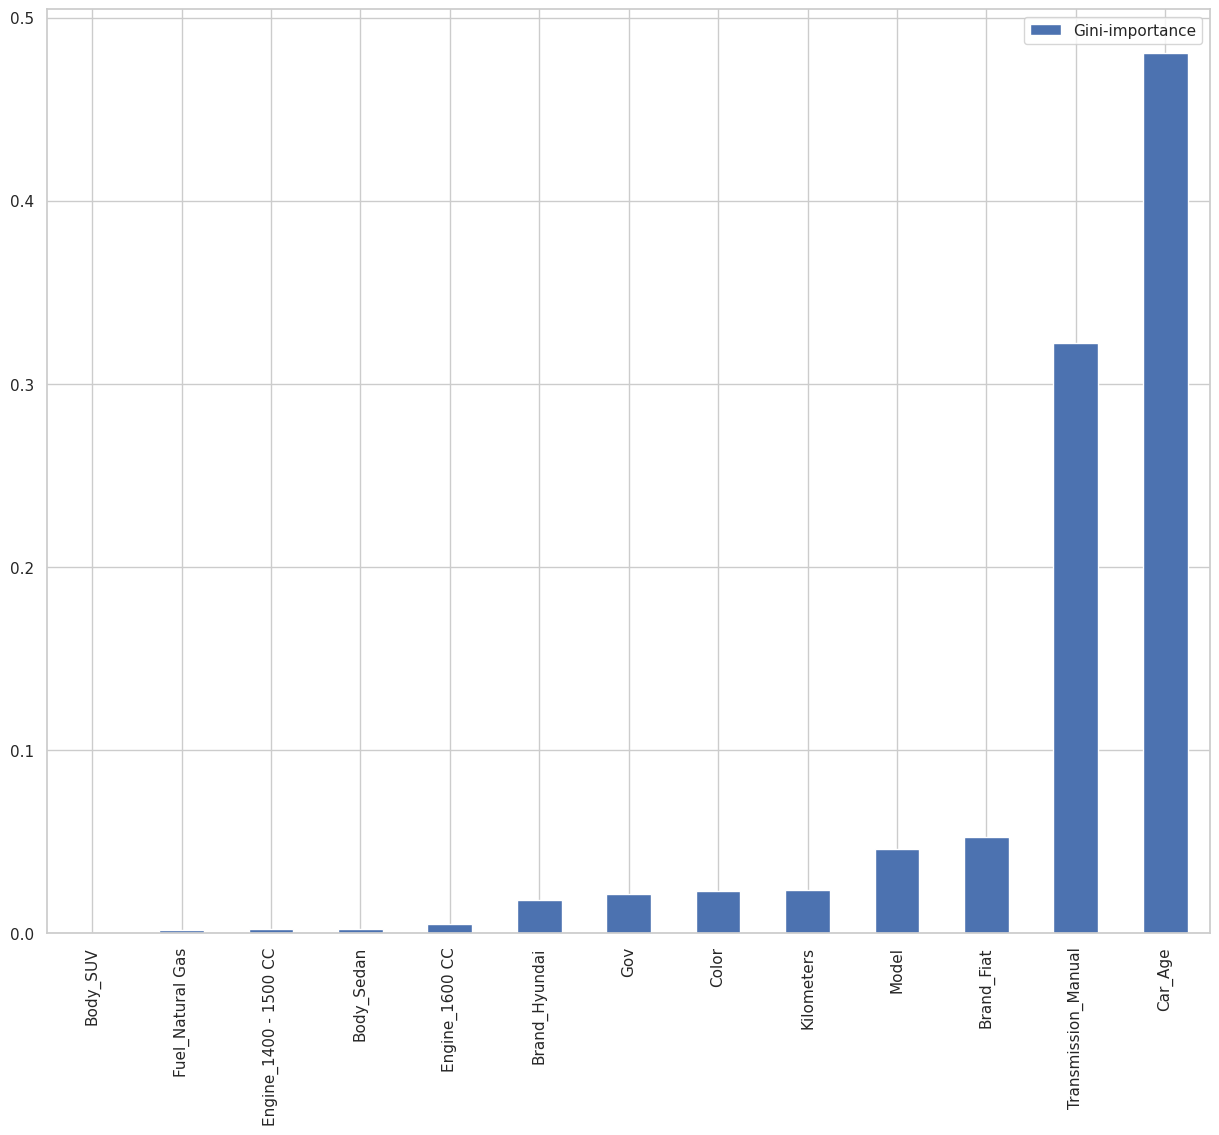

In [ ]:
feature_names = [f'feature {i}' for i in range((X.shape[1]))]
forest = RandomForestRegressor (random_state=42)
forest.fit (x_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
  feats[feature] = importance #add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values (by='Gini-importance').plot(kind='bar', rot=90, figsize= (15,12))
plt.show()

<ipython-input-53-506339c13546>:7: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,13,1)


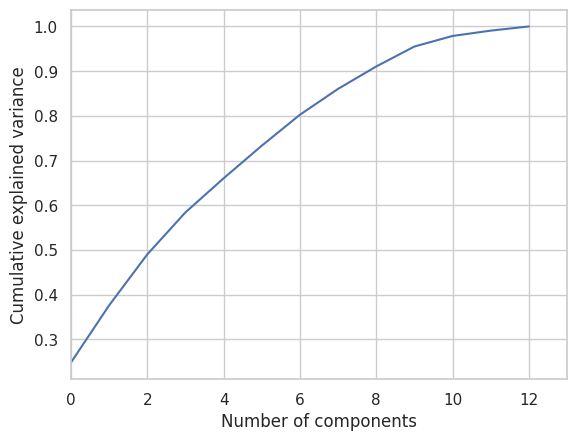

In [ ]:
X_Train=x_train.values
X_Train=np.asarray(X_Train)
# Finding normalised array of X_Train
x_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(x_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,13,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
sclr = StandardScaler()
x_train[x_train.columns] = sclr.fit_transform(x_train[x_train.columns])
x_test[x_test.columns] = sclr.transform(x_test[x_test.columns])

In [ ]:

models = {
    'LinearRegression' : LinearRegression() ,
    'KNN' : KNeighborsRegressor(),
    'DecisionTree' : DecisionTreeRegressor(),
    'RandomForest' : RandomForestRegressor(),
    'XGB' : XGBRegressor(),
    'AdaBoost' : AdaBoostRegressor(),
    'LGBM' : LGBMRegressor(),
 #   'CatBoost' : CatBoostRegressor()
}


data = {

        'full_dataset' : X.columns ,
        '40_features' : importances.sort_values(by='Gini-importance')[-40:].index.tolist() ,
        '20_features' : importances.sort_values(by='Gini-importance')[-20:].index.tolist() ,
        '10_features' : importances.sort_values(by='Gini-importance')[-10:].index.tolist()
}

In [ ]:
for feature_names , feature in data.items():
  train_score = []
  test_score = []
  Regressor = []
  for model_name , model in models.items() :
    #print(f'training with {feature_names}')
    scores = cross_validate(estimator=model , X=X[feature], y=y , cv=KFold(n_splits=5),scoring='r2',return_train_score=True)
    #print(f'Train r2 score is : {r2_score(y_train , train)}')
    #print(f'Test r2 score is : {r2_score(y_test , test)}')
    Regressor.append(model_name)
    train_score.append(scores['train_score'].mean())
    test_score.append(scores['test_score'].mean())
  print(f'training with {feature_names} results: ')

  #print(Regressor)
  #print(train_score)
  #print(test_score)
  final = pd.DataFrame({
      'Model' : Regressor ,
      'r2_train' : train_score ,
      'r2_test' : test_score
    })

  display(final)
  print('*' * 50)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 13
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 13
[LightGBM] [Info] Start training from score 104.506546
[LightGBM] [Warning]

,Model,r2_train,r2_test
0,LinearRegression,0.787514,0.646641
1,KNN,0.913669,0.592663
2,DecisionTree,0.987552,0.705622
3,RandomForest,0.979281,0.795165
4,XGB,0.960980,0.784568
5,AdaBoost,0.818786,0.586366
6,LGBM,0.933084,0.805095


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 13
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 13
[LightGBM] [Info] Start 

,Model,r2_train,r2_test
0,LinearRegression,0.787514,0.646641
1,KNN,0.913348,0.592327
2,DecisionTree,0.987552,0.707431
3,RandomForest,0.979410,0.797867
4,XGB,0.960980,0.798195
5,AdaBoost,0.816699,0.613627
6,LGBM,0.933084,0.805722


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 13
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 13
[LightGBM] [Info] Start 

,Model,r2_train,r2_test
0,LinearRegression,0.787514,0.646641
1,KNN,0.913348,0.592327
2,DecisionTree,0.987552,0.720227
3,RandomForest,0.979268,0.795455
4,XGB,0.960980,0.798195
5,AdaBoost,0.808759,0.610317
6,LGBM,0.933084,0.805722


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 10
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 10
[LightGBM] [Info] Start 

,Model,r2_train,r2_test
0,LinearRegression,0.783222,0.649130
1,KNN,0.911354,0.581063
2,DecisionTree,0.987190,0.708870
3,RandomForest,0.979051,0.793048
4,XGB,0.960679,0.799045
5,AdaBoost,0.813483,0.589666
6,LGBM,0.932928,0.807705


**************************************************


In [ ]:
for feature_names , feature in data.items():
  train_score = []
  test_score = []
  Regressor = []
  for model_name , model in models.items() :
    #print(f'training with {feature_names}')
    mdl = model
    mdl.fit(x_train[feature] , y_train)
    train = mdl.predict(x_train[feature])
    test = mdl.predict(x_test[feature])
    #print(f'Train r2 score is : {r2_score(y_train , train)}')
    #print(f'Test r2 score is : {r2_score(y_test , test)}')
    Regressor.append(model_name)
    train_score.append(r2_score(y_train , train))
    test_score.append(r2_score(y_test , test))
  print(f'training with {feature_names} results: ')

  #print(Regressor)
  #print(train_score)
  #print(test_score)
  final = pd.DataFrame({
      'Model' : Regressor ,
      'r2_train' : train_score ,
      'r2_test' : test_score
    })

  display(final)
  print('*' * 50)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 13
[LightGBM] [Info] Start training from score 116.685728
training with full_dataset results: 


,Model,r2_train,r2_test
0,LinearRegression,0.791228,0.777894
1,KNN,0.929819,0.883570
2,DecisionTree,0.988310,0.883992
3,RandomForest,0.980454,0.916478
4,XGB,0.960740,0.924764
5,AdaBoost,0.825244,0.815752
6,LGBM,0.936113,0.912053


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 13
[LightGBM] [Info] Start training from score 116.685728
training with 40_features results: 


,Model,r2_train,r2_test
0,LinearRegression,0.791228,0.777894
1,KNN,0.929828,0.883570
2,DecisionTree,0.988310,0.880034
3,RandomForest,0.980528,0.917705
4,XGB,0.960740,0.924669
5,AdaBoost,0.832993,0.826221
6,LGBM,0.936113,0.912053


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 13
[LightGBM] [Info] Start training from score 116.685728
training with 20_features results: 


,Model,r2_train,r2_test
0,LinearRegression,0.791228,0.777894
1,KNN,0.929828,0.883570
2,DecisionTree,0.988310,0.879201
3,RandomForest,0.980328,0.916131
4,XGB,0.960740,0.924669
5,AdaBoost,0.823960,0.818260
6,LGBM,0.936113,0.912053


**************************************************
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 10
[LightGBM] [Info] Start training from score 116.685728
training with 10_features results: 


,Model,r2_train,r2_test
0,LinearRegression,0.786880,0.775031
1,KNN,0.929661,0.883163
2,DecisionTree,0.988121,0.879963
3,RandomForest,0.980273,0.914659
4,XGB,0.962207,0.925373
5,AdaBoost,0.815157,0.810236
6,LGBM,0.935521,0.911667


**************************************************


# Pipeline

In [ ]:
df = pd.read_csv('/content/Cars.csv')
df

,Unnamed: 0,Brand,Model,Body,Color,Year,Fuel,Kilometers,Engine,Transmission,Price,Gov
0,5337,Hyundai,Accent,Sedan,Black,2007,Benzine,140000 to 159999,1600 CC,Automatic,140.0,Giza
1,5338,Hyundai,Accent,Sedan,Silver,2005,Benzine,180000 to 199999,1000 - 1300 CC,Manual,78.0,Qena
2,5339,Hyundai,Accent,Sedan,Gray,1999,Benzine,140000 to 159999,1400 - 1500 CC,Manual,70.0,Giza
3,5340,Hyundai,Accent,Sedan,Blue- Navy Blue,2009,Benzine,140000 to 159999,1600 CC,Automatic,150.0,Cairo
4,5341,Hyundai,Accent,Sedan,Silver,2000,Benzine,10000 to 19999,1000 - 1300 CC,Manual,75.0,Giza
...,...,...,...,...,...,...,...,...,...,...,...,...
14736,14209,Fiat,Uno,Hatchback,Burgundy,1997,Benzine,160000 to 179999,1000 - 1300 CC,Manual,46.0,Cairo
14737,14210,Fiat,Uno,Hatchback,Silver,1996,Benzine,20000 to 29999,1000 - 1300 CC,Manual,46.0,Alexandria
14738,14211,Fiat,Uno,Hatchback,Burgundy,1993,Benzine,10000 to 19999,1000 - 1300 CC,Manual,43.7,Giza
14739,14212,Fiat,Uno,Hatchback,Silver,1996,Benzine,10000 to 19999,1000 - 1300 CC,Manual,69.0,Cairo


In [ ]:
def drop_first_column(x) :
  return x[x.columns[1:]]

def age_column(x):
  x['Car_Age'] = 2023 - x['Year']
  x.drop('Year' , axis=1 , inplace=True)
  return x



In [ ]:
drop_first = FunctionTransformer(drop_first_column)
age_transform = FunctionTransformer(age_column)

In [ ]:
encoding = ColumnTransformer(transformers=[
       ('pass' , 'passthrough', make_column_selector(dtype_include=np.number)),

       ('Ordinal', OrdinalEncoder(categories=[['0 to 9999' , '10000 to 19999' ,'20000 to 29999'  ,'30000 to 39999'  ,'40000 to 49999'  ,'50000 to 59999'  ,'60000 to 69999'  ,'70000 to 79999'  ,'80000 to 89999'  ,'90000 to 99999'  ,'100000 to 119999' ,'120000 to 139999'  ,'140000 to 159999' ,'160000 to 179999' ,'180000 to 199999' ,'More than 200000']]) , ['Kilometers'] ),
       ('Binary' , BinaryEncoder() , ['Model' , 'Color' , 'Gov']),
       ('Ohe' , OneHotEncoder(sparse_output=False , drop='first') , ['Brand' , 'Body' , 'Fuel' , 'Transmission' , 'Engine'])

] , verbose_feature_names_out=False).set_output(transform='pandas')

In [ ]:
['0 to 9999' , '10000 to 19999' ,'20000 to 29999'  ,'30000 to 39999'  ,'40000 to 49999'  ,'50000 to 59999'  ,'60000 to 69999'  ,'70000 to 79999'  ,'80000 to 89999'  ,'90000 to 99999'  ,'100000 to 119999' ,'120000 to 139999'  ,'140000 to 159999' ,'160000 to 179999' ,'180000 to 199999' ,'More than 200000']

In [ ]:

#models = {
 #   'LinearRegression' : LinearRegression() ,
  #  'KNN' : KNeighborsRegressor(),
   # 'DecisionTree' : DecisionTreeRegressor(),
    #'RandomForest' : RandomForestRegressor(),
    #'XGB' : XGBRegressor(),
    #'AdaBoost' : AdaBoostRegressor(),
    #'LGBM' : LGBMRegressor(),
    #'CatBoost' : CatBoostRegressor()
#}

params = [

  {
      'clf' : [LinearRegression()]

  } ,


  {
      'clf' : [KNeighborsRegressor()],
      'clf__n_neighbors' : [3,5,7]
  } ,

  {

       'clf' : [DecisionTreeRegressor()],
       'clf__max_depth' : [None , 6,7,8]

  },

  {
       'clf' : [RandomForestRegressor()],
       'clf__max_depth' : [None , 6,7,8],
       'clf__n_estimators' : [50,75,100]
  } ,

  {
      'clf' : [LGBMRegressor()],
      'clf__max_depth' : [None , 6,7,8]
  },

  {
    'clf' : [XGBRegressor()],
    'clf__max_depth' : [None ,6,7,8],
    'clf__gamma':[10,50,100,500]
  }
    ,
  {
      'clf' : [CatBoostRegressor()],
     'clf__max_depth' : [None,6,7,8]
  } ,

  {
        'clf' : [AdaBoostRegressor()]
       # 'clf__max_depth' : [None,6,7,8]
  }
]

In [ ]:
X , y = df.drop('Price' , axis=1) , df['Price']

In [ ]:

#models = {
 #   'LinearRegression' : LinearRegression() ,
  #  'KNN' : KNeighborsRegressor(),
   # 'DecisionTree' : DecisionTreeRegressor(),
    #'RandomForest' : RandomForestRegressor(),
    #'XGB' : XGBRegressor(),
    #'AdaBoost' : AdaBoostRegressor(),
    #'LGBM' : LGBMRegressor(),
    #'CatBoost' : CatBoostRegressor()
#}

params = [

  {
      'clf' : [LinearRegression()]

  } ,


  {
      'clf' : [KNeighborsRegressor()],
      'clf__n_neighbors' : [3,5,7]
  } ,

  {

       'clf' : [DecisionTreeRegressor()],
       'clf__max_depth' : [None , 6,7,8]

  },

  {
       'clf' : [RandomForestRegressor()],
       'clf__max_depth' : [None , 6,7,8],
       'clf__n_estimators' : [50,75,100]
  } ,

  {
      'clf' : [LGBMRegressor()],
      'clf__max_depth' : [None , 6,7,8]
  },

  {
    'clf' : [XGBRegressor()],
    'clf__max_depth' : [None ,6,7,8]
    #'clf__gamma' : [50,100,500]
  }
    ,
  {
      'clf' : [CatBoostRegressor()],
     'clf__max_depth' : [None,6,7,8]
  } ,

  {
        'clf' : [AdaBoostRegressor()]
       # 'clf__max_depth' : [None,6,7,8]
  }
]

model_name = []
train_mse = []
test_mse = []
train_mae = []
test_mae = []
train_rmse = []
test_rmse = []
train_r2 = []
test_r2 = []
best_score = []
best_estimator = []


for param in params :

  name = param['clf'][0]
  pipeline = Pipeline(steps=[
      ('drop_first' , drop_first) ,
      ('age' , age_transform),
      ('encode' , encoding),
      ('sclr' , StandardScaler()),
      ('clf' , name)
  ])

  param.pop('clf')

  grid = GridSearchCV(estimator=pipeline , param_grid = param , cv=KFold(n_splits=5),refit = 'neg_mean_squared_error',scoring=['neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error' , 'r2'],return_train_score=True)
    #print(f'Train r2 score is : {r2_score(y_train , train)}')
  grid.fit(X,y)
    #print(f'Test r2 score is : {r2_score(y_test , test)}')
    #print(scores)
  #print(len(grid.cv_results_))
  display(pd.DataFrame(grid.cv_results_))
  model_name.append(str(name))
  train_mse.append(grid.cv_results_['mean_train_neg_mean_squared_error'].mean() * -1)
  test_mse.append(grid.cv_results_['mean_test_neg_mean_squared_error'].mean() * -1)
  train_r2.append(grid.cv_results_['mean_train_r2'].mean())
  test_r2.append(grid.cv_results_['mean_test_r2'].mean())
  train_rmse.append(grid.cv_results_['mean_train_neg_root_mean_squared_error'].mean() * -1)
  test_rmse.append(grid.cv_results_['mean_test_neg_root_mean_squared_error'].mean() * -1)
  train_mae.append(grid.cv_results_['mean_train_neg_mean_absolute_error'].mean() * -1)
  test_mae.append(grid.cv_results_['mean_test_neg_mean_absolute_error'].mean() * -1)
  best_estimator.append(grid.best_estimator_)
  best_score.append(grid.best_score_ * -1)
  param['clf'] = [name]


final = pd.DataFrame({
    'Model' : model_name,
    'train_mse' : train_mse ,
    'test_mse' : test_mse,
    'train_rmse' : train_rmse,
    'test_rmes' : test_rmse,
    'train_mae' : train_mae,
    'test_mae' : test_mae,
    'train_r2' : train_r2,
    'test_r2' : test_r2,
    'best_score' : best_score ,
    'best_estimator' : best_estimator
})

final

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,0.447809,0.108153,0.104586,0.021045,{},-27.919086,-32.825249,-32.364915,-27.122245,-34.389844,...,0.582547,0.218118,1,0.807016,0.807366,0.81466,0.790314,0.793017,0.802475,0.009277


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_neighbors,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,0.136779,0.077774,0.212098,0.048041,3,{'clf__n_neighbors': 3},-28.242738,-28.654048,-23.563286,-10.690412,...,0.707177,0.139339,1,0.940560,0.944302,0.955220,0.943912,0.936840,0.944167,0.006147
1,0.096874,0.005150,0.181946,0.011006,5,{'clf__n_neighbors': 5},-30.028891,-30.509953,-23.915699,-11.230190,...,0.683259,0.144807,2,0.917955,0.922021,0.920234,0.901163,0.884951,0.909265,0.014250
2,0.122249,0.033275,0.262010,0.100923,7,{'clf__n_neighbors': 7},-31.198774,-31.784231,-23.932109,-11.644733,...,0.667872,0.149937,3,0.904246,0.907838,0.902433,0.878123,0.856280,0.889784,0.019767


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,0.144425,0.005817,0.027985,0.002006,None,{'clf__max_depth': None},-24.431545,-28.010742,-20.276436,-11.615051,...,0.766339,0.112239,2,0.991058,0.991324,0.987808,0.984862,0.982708,0.987552,0.003385
1,0.112788,0.002976,0.025564,0.000548,6,{'clf__max_depth': 6},-25.722685,-32.041689,-19.725520,-11.128378,...,0.757216,0.122840,3,0.912224,0.914356,0.889178,0.862677,0.851073,0.885902,0.025556
2,0.114820,0.007397,0.026181,0.002534,7,{'clf__max_depth': 7},-24.077725,-29.929779,-20.122378,-10.796295,...,0.742422,0.111653,4,0.924303,0.923053,0.901812,0.881932,0.866420,0.899504,0.022708
3,0.114143,0.004977,0.025700,0.001148,8,{'clf__max_depth': 8},-22.213312,-27.565104,-18.812793,-10.278634,...,0.779716,0.111011,1,0.933432,0.931965,0.914273,0.893380,0.880410,0.910692,0.020972


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,1.765368,0.242886,0.057821,0.006272,None,50,"{'clf__max_depth': None, 'clf__n_estimators': 50}",-19.794409,-23.135193,-16.690269,...,0.825936,0.071088,2,0.982063,0.983188,0.981013,0.976078,0.972590,0.978986,0.004015
1,2.542456,0.406727,0.068256,0.002636,None,75,"{'clf__max_depth': None, 'clf__n_estimators': 75}",-19.782316,-23.085871,-16.560584,...,0.828265,0.069695,1,0.982758,0.983564,0.981301,0.976355,0.972749,0.979345,0.004141
2,3.361325,0.459766,0.085363,0.004103,None,100,"{'clf__max_depth': None, 'clf__n_estimators': ...",-19.779699,-23.083121,-16.606316,...,0.825099,0.070931,3,0.982657,0.983674,0.981498,0.976431,0.973096,0.979471,0.004045
3,0.684360,0.092700,0.037016,0.002401,6,50,"{'clf__max_depth': 6, 'clf__n_estimators': 50}",-24.897577,-30.495278,-18.941346,...,0.757240,0.102705,12,0.915811,0.919014,0.896462,0.870328,0.859776,0.892278,0.023767
4,0.934219,0.079005,0.041779,0.002873,6,75,"{'clf__max_depth': 6, 'clf__n_estimators': 75}",-24.822282,-30.257503,-18.997380,...,0.759275,0.103878,11,0.915667,0.919254,0.895031,0.870263,0.861064,0.892256,0.023415
5,1.601751,0.600051,0.079926,0.065070,6,100,"{'clf__max_depth': 6, 'clf__n_estimators': 100}",-24.839465,-30.213745,-18.678469,...,0.761394,0.101107,10,0.915714,0.919410,0.897233,0.870563,0.861164,0.892817,0.023444
6,0.716655,0.011876,0.036710,0.002044,7,50,"{'clf__max_depth': 7, 'clf__n_estimators': 50}",-22.638467,-27.396289,-17.983257,...,0.779202,0.091923,7,0.929135,0.929597,0.909432,0.887960,0.875792,0.906383,0.021638
7,1.200344,0.257728,0.045993,0.008938,7,75,"{'clf__max_depth': 7, 'clf__n_estimators': 75}",-22.471215,-27.292003,-17.986635,...,0.777800,0.091405,9,0.928879,0.930172,0.909528,0.887918,0.876208,0.906541,0.021602
8,1.409450,0.201750,0.049352,0.008861,7,100,"{'clf__max_depth': 7, 'clf__n_estimators': 100}",-22.572292,-27.170248,-17.924642,...,0.778843,0.091113,8,0.928830,0.930196,0.909860,0.888142,0.875931,0.906592,0.021647
9,0.874953,0.197590,0.040074,0.006708,8,50,"{'clf__max_depth': 8, 'clf__n_estimators': 50}",-21.547695,-25.888191,-17.430351,...,0.792022,0.086124,5,0.937543,0.938298,0.920128,0.898655,0.888405,0.916606,0.020193


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 11792, number of used features: 24
[LightGBM] [Info] Start training from score 109.666622
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 11793, number of used features: 24
[LightGBM] [Info] Start training from score 104.506546
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,0.349740,0.085968,0.052147,0.007339,None,{'clf__max_depth': None},-19.839155,-23.463576,-16.071294,-9.422978,...,0.819651,0.073201,2,0.946655,0.948556,0.938267,0.919981,0.907985,0.932289,0.015805
1,0.289879,0.067137,0.046112,0.008494,6,{'clf__max_depth': 6},-19.940392,-23.690267,-15.394138,-9.441213,...,0.817776,0.072342,4,0.942635,0.945465,0.933585,0.913150,0.901318,0.927231,0.017204
2,0.252951,0.005892,0.041094,0.003035,7,{'clf__max_depth': 7},-19.793474,-23.622017,-15.810295,-9.344425,...,0.818683,0.074202,3,0.944929,0.946449,0.936336,0.916342,0.904301,0.929671,0.016613
3,0.252268,0.012153,0.043326,0.004756,8,{'clf__max_depth': 8},-19.825160,-23.407629,-15.681485,-9.420659,...,0.820229,0.072406,1,0.945390,0.947611,0.938900,0.917643,0.905707,0.931050,0.016514


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,0.252384,0.013708,0.035871,0.000964,None,{'clf__max_depth': None},-18.551163,-21.671483,-16.431026,-9.069789,...,0.826677,0.075335,3,0.966856,0.968694,0.963783,0.950677,0.944092,0.958821,0.009695
1,0.262985,0.020143,0.038869,0.003985,6,{'clf__max_depth': 6},-18.551163,-21.671483,-16.431026,-9.069789,...,0.826677,0.075335,3,0.966856,0.968694,0.963783,0.950677,0.944092,0.958821,0.009695
2,0.579660,0.449511,0.040655,0.007282,7,{'clf__max_depth': 7},-18.031129,-21.552485,-16.992835,-8.939435,...,0.833725,0.076882,1,0.978234,0.978409,0.974663,0.966055,0.960927,0.971658,0.006991
3,0.341907,0.026548,0.037861,0.001212,8,{'clf__max_depth': 8},-18.738073,-21.393005,-17.309815,-8.855589,...,0.829703,0.079204,2,0.985080,0.985403,0.982066,0.976710,0.971783,0.980208,0.005242


Streaming output truncated to the last 5000 lines.
4:	learn: 60.8216770	total: 24.5ms	remaining: 4.88s
5:	learn: 57.9366976	total: 29.9ms	remaining: 4.95s
6:	learn: 55.0943758	total: 35.1ms	remaining: 4.97s
7:	learn: 52.4510797	total: 40.2ms	remaining: 4.98s
8:	learn: 50.0072315	total: 43.3ms	remaining: 4.77s
9:	learn: 47.6970771	total: 48.2ms	remaining: 4.77s
10:	learn: 45.6601970	total: 53.2ms	remaining: 4.79s
11:	learn: 43.6985724	total: 58.5ms	remaining: 4.82s
12:	learn: 41.9302086	total: 63.8ms	remaining: 4.84s
13:	learn: 40.2143588	total: 68.8ms	remaining: 4.85s
14:	learn: 38.7030619	total: 74.1ms	remaining: 4.87s
15:	learn: 37.2873161	total: 79.8ms	remaining: 4.91s
16:	learn: 35.9296606	total: 85.3ms	remaining: 4.93s
17:	learn: 34.7035879	total: 90.7ms	remaining: 4.95s
18:	learn: 33.5421138	total: 96.4ms	remaining: 4.98s
19:	learn: 32.4442398	total: 102ms	remaining: 5s
20:	learn: 31.4433243	total: 108ms	remaining: 5.02s
21:	learn: 30.4817498	total: 113ms	remaining: 5.03s
22:	lea

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,3.357383,0.503420,0.037344,0.009494,None,{'clf__max_depth': None},-17.746798,-21.490627,-14.811765,-8.875965,...,0.813604,0.087945,3,0.958067,0.960125,0.953549,0.939516,0.929407,0.948133,0.011804
1,3.614016,0.639825,0.035758,0.005847,6,{'clf__max_depth': 6},-17.746798,-21.490627,-14.811765,-8.875965,...,0.813604,0.087945,3,0.958067,0.960125,0.953549,0.939516,0.929407,0.948133,0.011804
2,4.594703,0.573566,0.036209,0.005852,7,{'clf__max_depth': 7},-17.301719,-21.063372,-14.727629,-8.730856,...,0.817975,0.092164,2,0.965731,0.967253,0.962373,0.950339,0.942647,0.957669,0.009575
3,6.566784,0.685981,0.032076,0.003175,8,{'clf__max_depth': 8},-16.477538,-20.161878,-14.587952,-8.483928,...,0.822879,0.098411,1,0.972724,0.973778,0.970180,0.960359,0.954255,0.966259,0.007650


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,...,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2
0,0.365283,0.095427,0.031638,0.002872,{},-36.318355,-41.577386,-22.944732,-15.639656,-22.185134,...,0.636187,0.169562,1,0.851126,0.861989,0.840994,0.7895,0.768085,0.822339,0.036799


,Model,train_mse,test_mse,train_rmse,test_rmes,train_mae,test_mae,train_r2,test_r2,best_score,best_estimator
0,LinearRegression(),1308.521586,1765.586273,36.142140,41.769011,25.374955,30.924268,0.802475,0.582547,1765.586273,(FunctionTransformer(func=<function drop_first...
1,KNeighborsRegressor(),562.191831,1451.315548,23.459047,36.653470,14.233359,23.175459,0.914405,0.686103,1353.532019,(FunctionTransformer(func=<function drop_first...
2,DecisionTreeRegressor(),519.796114,1098.685207,21.473858,31.817610,12.145546,19.994652,0.920912,0.761423,994.720147,(FunctionTransformer(func=<function drop_first...
3,RandomForestRegressor(),501.194052,1017.920932,21.503359,30.479625,12.589387,18.625702,0.923752,0.789044,836.139453,(FunctionTransformer(func=<function drop_first...
4,LGBMRegressor(),458.258424,881.875998,21.308486,28.359690,12.540514,16.849571,0.930060,0.819085,872.940562,(FunctionTransformer(func=<function drop_first...
5,"XGBRegressor(base_score=None, booster=None, ca...",213.544213,831.337851,14.391875,27.378291,8.728146,16.574436,0.967377,0.829196,799.585399,(FunctionTransformer(func=<function drop_first...
6,<catboost.core.CatBoostRegressor object at 0x7...,294.462796,994.463105,17.029902,28.888582,10.277878,16.494846,0.955048,0.817015,971.310037,(FunctionTransformer(func=<function drop_first...
7,AdaBoostRegressor(),1166.163481,1746.499391,34.032098,39.785061,22.957924,27.733053,0.822339,0.636187,1746.499391,(FunctionTransformer(func=<function drop_first...


In [ ]:
final[['best_estimator']].loc[5][0]

Pipeline(steps=[('drop_first',
                 FunctionTransformer(func=<function drop_first_column at 0x7d9da4343e20>)),
                ('age',
                 FunctionTransformer(func=<function age_column at 0x7d9da878fd90>)),
                ('encode',
                 ColumnTransformer(transformers=[('pass', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d9d9f74fa00>),
                                                 ('Ordinal',
                                                  OrdinalEncoder(catego...
                              feature_types=None, gamma=100, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

# Pipeline - optuna

In [ ]:
def drop_first_column(x) :
  return x[x.columns[1:]]

def age_column(x):
  x['Car_Age'] = 2023 - x['Year']
  x.drop('Year' , axis=1 , inplace=True)
  return x



In [ ]:
drop_first = FunctionTransformer(drop_first_column)
age_transform = FunctionTransformer(age_column)

In [ ]:
encoding = ColumnTransformer(transformers=[
       ('pass' , 'passthrough', make_column_selector(dtype_include=np.number)),

       ('Ordinal', OrdinalEncoder(categories=[['0 to 9999' , '10000 to 19999' ,'20000 to 29999'  ,'30000 to 39999'  ,'40000 to 49999'  ,'50000 to 59999'  ,'60000 to 69999'  ,'70000 to 79999'  ,'80000 to 89999'  ,'90000 to 99999'  ,'100000 to 119999' ,'120000 to 139999'  ,'140000 to 159999' ,'160000 to 179999' ,'180000 to 199999' ,'More than 200000']]) , ['Kilometers'] ),
       ('Binary' , BinaryEncoder() , ['Model' , 'Color' , 'Gov']),
       ('Ohe' , OneHotEncoder(sparse_output=False , drop='first') , ['Brand' , 'Body' , 'Fuel' , 'Transmission' , 'Engine'])

] , verbose_feature_names_out=False).set_output(transform='pandas')

In [ ]:
X , y = df.drop('Price' , axis=1) , df['Price']

In [ ]:
models = {
 #   'LinearRegression' : LinearRegression ,
    #'KNN' : KNeighborsRegressor,
    #'DecisionTree' : DecisionTreeRegressor,
    'RandomForest' : RandomForestRegressor,
    'XGB' :XGBRegressor,
    'LGBM' : LGBMRegressor,
    #'Adaboost' : AdaBoostRegressor ,
    #'CatBoost' : CatBoostRegressor
}
def objective(trial)  :

   X , y = df.drop('Price',axis=1) , df['Price']
   param = get_params(trial)
   print(Model(**param))


   model = Pipeline(steps=[

          ('drop_dirst' , drop_first),
          ('age_transform' , age_transform),
          ('encode' , encoding),
          ('sclr' , StandardScaler()),
          (model_name , Model(**param))
      ])



   scores = cross_val_score(model,X,y,cv=KFold(7) , scoring = 'r2')

   return scores.mean()


def get_params(trial) :

   params = {


       #   'LinearRegression' : {
        #                          'fit_intercept' : choice([True,False])
         #                     },

          #'KNN'              : {
               #                   'n_neighbors' : trial.suggest_int('n_neighbors' , 1 , 8)
                #              } ,
         # 'DecisionTree'     : {
          #                        'max_depth' : trial.suggest_int('max_depth',1,10),
           #                       'splitter'  : choice(['best' , 'random']),
            #                      'max_features' : trial.suggest_uniform('max_features' ,0 ,1)
             #                 },
          'RandomForest'     : {
                                  'max_depth' : trial.suggest_int('max_depth' , 1 , 50),
                                  'n_estimators' : trial.suggest_int('n_estimators' , 50 , 300),
                                  'max_features' : trial.suggest_uniform('max_features',0,1),
                                #  'min_samples_split' : trial.suggest_int('min_samples_split',2,4),
                                  'bootstrap' : trial.suggest_categorical('bootstrap' , [True,False])
                                },
          'XGB'              : {
                                  'max_depth' : trial.suggest_int('max_depth' , 10 , 40),
                                  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
                                  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
                                  'colsample_bynode' : trial.suggest_uniform('colsample_bynode' ,0,1),
                                 # 'subsample' : trial.suggest_uniform('subsample',0.01 , 1),
                                  'eta' : trial.suggest_uniform('eta',0,1),
                                  'lambda' : trial.suggest_int('lambda',0,1000),
                                  'alpha' : trial.suggest_int('alpha',0,1000),
                                  'gamma' : trial.suggest_int('gamma' ,0 , 1000),
                                  'n_estimators': trial.suggest_int('n_estimators',50,500),
                                 # 'learning_rate' : trial.suggest_float('learning_rate',1,10)
                                },
           'LGBM'             : {
                                  'max_depth' : trial.suggest_int('max_depth',1,40),
                                  'num_leaves' : trial.suggest_int('num_leaves' , 10 , 70),
                                  'learning_rate' : trial.suggest_uniform('learning_rate',0,1),
                                  'n_estimators' : trial.suggest_int('n_estimators',50,300),
                                  'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0,1),
                                  'reg_alpha' : trial.suggest_float('reg_alpha',0,1000),
                                  'reg_lambda' : trial.suggest_float('reg_lambda',0,1000)
                                }
          #'Adaboost'         : {
           #                       'n_estimators' : trial.suggest_int('n_estimators',1,100),
            #                      'learning_rate' : trial.suggest_float('learning_rate',1,10),
             #                     'loss' : choice(['linear','square','exponential'])
              #                  },
          #'CatBoost'         : {
           #                       'learning_rate' : trial.suggest_uniform('learning_rate' ,0 ,1),
            #                      'depth' : trial.suggest_int('depth',1,10)
             #                   }
        }

   return params[model_name]




modelname = []
best_estimator = []


for model_name , Model in models.items() :


  if model_name == 'RandomForest' :
    trials = 50
  elif model_name == 'LGBM' :
    trials = 25
  else:
    trials = 200

  study = create_study(study_name= model_name , direction='maximize')
  study.optimize(objective, n_trials=trials)
  modelname.append(model_name)
 # train_r2.append(optuna.cv_results_['mean_train_r2'].mean())
 # test_r2.append(optuna.cv_results_['mean_test_r2'].mean())
 # train_rmse.append(grid.cv_results_['mean_train_neg_root_mean_squared_error'].mean() * -1)
 # test_rmse.append(optuna.cv_results_['mean_test_neg_root_mean_squared_error'].mean() * -1)
 # train_mae.append(optuna.cv_results_['mean_train_neg_mean_absolute_error'].mean() * -1)
 # test_mae.append(optuna.cv_results_['mean_test_neg_mean_absolute_error'].mean() * -1)
  best_estimator.append(Pipeline(steps=[

          ('drop_dirst' , drop_first),
          ('age_transform' , age_transform),
          ('encode' , encoding),
          ('sclr' , StandardScaler()),
          (model_name , Model(**study.best_params))
      ])
)
  #best_score.append(optuna.best_score_ * -1)




<ipython-input-108-dbdd2598e600>:120: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna = OptunaSearchCV(pipeline , param_distributions = param , n_trials=trials ,cv=KFold(n_splits=7),scoring='neg_mean_squared_error' ,return_train_score=True)
[I 2023-10-12 05:53:05,858] A new study created in memory with name: no-name-c5ce7ae5-eb1f-46ac-92dc-590d3637fe26
[I 2023-10-12 05:53:37,025] Trial 0 finished with value: -656.6567314482369 and parameters: {'clf__max_depth': 26, 'clf__n_estimators': 64, 'clf__max_features': 0.8653587981440136, 'clf__bootstrap': False}. Best is trial 0 with value: -656.6567314482369.
[I 2023-10-12 05:53:56,103] Trial 1 finished with value: -585.2972384452611 and parameters: {'clf__max_depth': 23, 'clf__n_estimators': 67, 'clf__max_features': 0.8151265061330435, 'clf__bootstrap': True}. Best is trial 1 with value: -585.2972384452611.
[I 2023-10-12 05:54:18,433] Trial 2 finished with value: 

[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:19:17,652] Trial 0 finished with value: -623.2449290629072 and parameters: {'clf__max_depth': 34, 'clf__num_leaves': 37, 'clf__learning_rate': 0.6597885875985953, 'clf__n_estimators': 141, 'clf__colsample_bytree': 0.44020688567447563, 'clf__reg_alpha': 0.7942093776995086, 'clf__ref_lambda': 0.7343050674711645}. Best is trial 0 with value: -623.2449290629072.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:19:25,338] Trial 1 finished with value: -527.4716089611536 and parameters: {'clf__max_depth': 35, 'clf__num_leaves': 52, 'clf__learning_rate': 0.30615933948561735, 'clf__n_estimators': 262, 'clf__colsample_bytree': 0.5364598511328103, 'clf__reg_alpha': 0.36397689743047157, 'clf__ref_lambda': 0.4013443187499358}. Best is trial 1 with value: -527.4716089611536.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:19:31,428] Trial 2 finished with value: -633.6808758546653 and parameters: {'clf__max_depth': 9, 'clf__num_leaves': 26, 'clf__learning_rate': 0.7702848946021407, 'clf__n_estimators': 169, 'clf__colsample_bytree': 0.3217442192637032, 'clf__reg_alpha': 0.1447703424835014, 'clf__ref_lambda': 0.4941536604279019}. Best is trial 1 with value: -527.4716089611536.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:19:37,355] Trial 3 finished with value: -521.7523273544301 and parameters: {'clf__max_depth': 21, 'clf__num_leaves': 44, 'clf__learning_rate': 0.31307133993868486, 'clf__n_estimators': 244, 'clf__colsample_bytree': 0.8821996646824104, 'clf__reg_alpha': 0.42611227955670206, 'clf__ref_lambda': 0.8120768054251375}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2023-10-12 06:19:44,550] Trial 4 finished with value: -577.43189636559 and parameters: {'clf__max_depth': 6, 'clf__num_leaves': 45, 'clf__learning_rate': 0.3325116552560209, 'clf__n_estimators': 184, 'clf__colsample_bytree': 0.6546830244473644, 'clf__reg_alpha': 0.7009228013514515, 'clf__ref_lambda': 0.9440971454701204}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:19:48,219] Trial 5 finished with value: -702.3825559975156 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 36, 'clf__learning_rate': 0.05506092721171918, 'clf__n_estimators': 87, 'clf__colsample_bytree': 0.8704667769981834, 'clf__reg_alpha': 0.9916466281668899, 'clf__ref_lambda': 0.955299442096617}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2023-10-12 06:19:56,559] Trial 6 finished with value: -589.2500694877982 and parameters: {'clf__max_depth': 37, 'clf__num_leaves': 32, 'clf__learning_rate': 0.6914537150372156, 'clf__n_estimators': 284, 'clf__colsample_bytree': 0.7471437321581282, 'clf__reg_alpha': 0.3561664085774078, 'clf__ref_lambda': 0.48695595223201327}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2023-10-12 06:20:04,616] Trial 7 finished with value: -1597.9246438726925 and parameters: {'clf__max_depth': 32, 'clf__num_leaves': 27, 'clf__learning_rate': 0.007936491252106492, 'clf__n_estimators': 284, 'clf__colsample_bytree': 0.1968499364901406, 'clf__reg_alpha': 0.47962329852075547, 'clf__ref_lambda': 0.42837284288227395}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:20:12,714] Trial 8 finished with value: -571.9657681935468 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 46, 'clf__learning_rate': 0.8060352453891458, 'clf__n_estimators': 281, 'clf__colsample_bytree': 0.8308978646540451, 'clf__reg_alpha': 0.32783049920645935, 'clf__ref_lambda': 0.9048144158530436}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2023-10-12 06:20:22,440] Trial 9 finished with value: -660.166266436728 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 68, 'clf__learning_rate': 0.7391499149290651, 'clf__n_estimators': 289, 'clf__colsample_bytree': 0.20916694140169068, 'clf__reg_alpha': 0.05906829659921409, 'clf__ref_lambda': 0.8123143301604742}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:20:27,164] Trial 10 finished with value: -611.4368115154932 and parameters: {'clf__max_depth': 25, 'clf__num_leaves': 14, 'clf__learning_rate': 0.9294290284866982, 'clf__n_estimators': 225, 'clf__colsample_bytree': 0.978445650751425, 'clf__reg_alpha': 0.6535811671875789, 'clf__ref_lambda': 0.03534580837116852}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:20:35,118] Trial 11 finished with value: -534.6957449254494 and parameters: {'clf__max_depth': 27, 'clf__num_leaves': 58, 'clf__learning_rate': 0.3648782887518207, 'clf__n_estimators': 229, 'clf__colsample_bytree': 0.5884236471263512, 'clf__reg_alpha': 0.25982227958394455, 'clf__ref_lambda': 0.6539971254158183}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:20:42,755] Trial 12 finished with value: -545.1008831447533 and parameters: {'clf__max_depth': 20, 'clf__num_leaves': 55, 'clf__learning_rate': 0.3023161574870751, 'clf__n_estimators': 231, 'clf__colsample_bytree': 0.5089791494136083, 'clf__reg_alpha': 0.4845921975950959, 'clf__ref_lambda': 0.2746452127235679}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2023-10-12 06:20:47,892] Trial 13 finished with value: -1237.192832195329 and parameters: {'clf__max_depth': 40, 'clf__num_leaves': 55, 'clf__learning_rate': 0.5018977612488944, 'clf__n_estimators': 245, 'clf__colsample_bytree': 0.005269028053624503, 'clf__reg_alpha': 0.2086428409490676, 'clf__ref_lambda': 0.6194828713490225}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:20:54,533] Trial 14 finished with value: -531.9460409814781 and parameters: {'clf__max_depth': 29, 'clf__num_leaves': 68, 'clf__learning_rate': 0.17713831948430592, 'clf__n_estimators': 193, 'clf__colsample_bytree': 0.9995219878119497, 'clf__reg_alpha': 0.012854378577940695, 'clf__ref_lambda': 0.7841205955348894}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:21:02,110] Trial 15 finished with value: -534.2269607940713 and parameters: {'clf__max_depth': 21, 'clf__num_leaves': 47, 'clf__learning_rate': 0.46268038832908426, 'clf__n_estimators': 258, 'clf__colsample_bytree': 0.7244746723042058, 'clf__reg_alpha': 0.3833637475906024, 'clf__ref_lambda': 0.3407131742414216}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:21:07,004] Trial 16 finished with value: -578.3849780609861 and parameters: {'clf__max_depth': 20, 'clf__num_leaves': 61, 'clf__learning_rate': 0.22212595751412761, 'clf__n_estimators': 119, 'clf__colsample_bytree': 0.6095799056076625, 'clf__reg_alpha': 0.553162265819594, 'clf__ref_lambda': 0.6248863709942004}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:21:09,955] Trial 17 finished with value: -598.136951096522 and parameters: {'clf__max_depth': 31, 'clf__num_leaves': 50, 'clf__learning_rate': 0.5135580584467003, 'clf__n_estimators': 55, 'clf__colsample_bytree': 0.8481223392612111, 'clf__reg_alpha': 0.40627938018686677, 'clf__ref_lambda': 0.5728651580674292}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

[I 2023-10-12 06:21:15,770] Trial 18 finished with value: -673.2703260351531 and parameters: {'clf__max_depth': 24, 'clf__num_leaves': 10, 'clf__learning_rate': 0.17535570580300097, 'clf__n_estimators': 197, 'clf__colsample_bytree': 0.4753720937119046, 'clf__reg_alpha': 0.26926740000055943, 'clf__ref_lambda': 0.8332938691554225}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:21:21,089] Trial 19 finished with value: -556.4235935832064 and parameters: {'clf__max_depth': 36, 'clf__num_leaves': 22, 'clf__learning_rate': 0.43446157625606335, 'clf__n_estimators': 261, 'clf__colsample_bytree': 0.7303552904391174, 'clf__reg_alpha': 0.16253541179187725, 'clf__ref_lambda': 0.997415696233178}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:21:26,779] Trial 20 finished with value: -544.5555190281586 and parameters: {'clf__max_depth': 27, 'clf__num_leaves': 41, 'clf__learning_rate': 0.5882446145904983, 'clf__n_estimators': 215, 'clf__colsample_bytree': 0.9190232756285586, 'clf__reg_alpha': 0.5443052309624882, 'clf__ref_lambda': 0.680142420443915}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:21:33,187] Trial 21 finished with value: -532.6366382824025 and parameters: {'clf__max_depth': 29, 'clf__num_leaves': 70, 'clf__learning_rate': 0.19936808664503788, 'clf__n_estimators': 166, 'clf__colsample_bytree': 0.9998843133532201, 'clf__reg_alpha': 0.06915574532604135, 'clf__ref_lambda': 0.7606882005953713}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:21:39,866] Trial 22 finished with value: -566.5998541688651 and parameters: {'clf__max_depth': 40, 'clf__num_leaves': 64, 'clf__learning_rate': 0.10786155012688581, 'clf__n_estimators': 200, 'clf__colsample_bytree': 0.9972336635297945, 'clf__reg_alpha': 0.0457484584390882, 'clf__ref_lambda': 0.8521965209801804}. Best is trial 3 with value: -521.7523273544301.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:21:47,691] Trial 23 finished with value: -511.37316140257616 and parameters: {'clf__max_depth': 31, 'clf__num_leaves': 51, 'clf__learning_rate': 0.28593182928510524, 'clf__n_estimators': 263, 'clf__colsample_bytree': 0.8016800210294295, 'clf__reg_alpha': 0.2887305174755198, 'clf__ref_lambda': 0.7384640219513743}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:21:55,623] Trial 24 finished with value: -511.5392158923498 and parameters: {'clf__max_depth': 34, 'clf__num_leaves': 53, 'clf__learning_rate': 0.2628210218775631, 'clf__n_estimators': 259, 'clf__colsample_bytree': 0.7949559313863621, 'clf__reg_alpha': 0.2886016910092638, 'clf__ref_lambda': 0.6954453954476044}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:22:01,705] Trial 25 finished with value: -524.3773998717893 and parameters: {'clf__max_depth': 32, 'clf__num_leaves': 42, 'clf__learning_rate': 0.3889029271424773, 'clf__n_estimators': 242, 'clf__colsample_bytree': 0.8027245359528131, 'clf__reg_alpha': 0.2728125024998924, 'clf__ref_lambda': 0.7246937202221613}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:22:09,659] Trial 26 finished with value: -522.230028039282 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 51, 'clf__learning_rate': 0.24547392428576592, 'clf__n_estimators': 265, 'clf__colsample_bytree': 0.8999868873996575, 'clf__reg_alpha': 0.43163069161108897, 'clf__ref_lambda': 0.8811601076274034}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:22:15,897] Trial 27 finished with value: -516.2170525347284 and parameters: {'clf__max_depth': 23, 'clf__num_leaves': 59, 'clf__learning_rate': 0.2865895682688827, 'clf__n_estimators': 212, 'clf__colsample_bytree': 0.800100648543463, 'clf__reg_alpha': 0.30371213455124363, 'clf__ref_lambda': 0.7125661451746715}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:22:25,172] Trial 28 finished with value: -528.7479786970705 and parameters: {'clf__max_depth': 38, 'clf__num_leaves': 61, 'clf__learning_rate': 0.14402916395433868, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.7624126538973128, 'clf__reg_alpha': 0.3016029931205328, 'clf__ref_lambda': 0.7070999544631198}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:22:29,802] Trial 29 finished with value: -569.582883421652 and parameters: {'clf__max_depth': 34, 'clf__num_leaves': 38, 'clf__learning_rate': 0.2533560223426491, 'clf__n_estimators': 159, 'clf__colsample_bytree': 0.668592098119893, 'clf__reg_alpha': 0.210141961383087, 'clf__ref_lambda': 0.7198360929569132}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:22:35,817] Trial 30 finished with value: -541.3995207257841 and parameters: {'clf__max_depth': 30, 'clf__num_leaves': 64, 'clf__learning_rate': 0.39296659669078393, 'clf__n_estimators': 141, 'clf__colsample_bytree': 0.6810126660112285, 'clf__reg_alpha': 0.3247058306614674, 'clf__ref_lambda': 0.5896154136388775}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:22:41,790] Trial 31 finished with value: -521.2120934933838 and parameters: {'clf__max_depth': 25, 'clf__num_leaves': 56, 'clf__learning_rate': 0.273664133045728, 'clf__n_estimators': 211, 'clf__colsample_bytree': 0.8210777633708091, 'clf__reg_alpha': 0.41524722407508674, 'clf__ref_lambda': 0.7905791071650451}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:22:48,391] Trial 32 finished with value: -517.9360627427908 and parameters: {'clf__max_depth': 25, 'clf__num_leaves': 54, 'clf__learning_rate': 0.26488355387343576, 'clf__n_estimators': 213, 'clf__colsample_bytree': 0.8005595638156563, 'clf__reg_alpha': 0.34080574581691325, 'clf__ref_lambda': 0.7515646110766148}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:22:54,422] Trial 33 finished with value: -525.3103950583104 and parameters: {'clf__max_depth': 34, 'clf__num_leaves': 50, 'clf__learning_rate': 0.26507273358765043, 'clf__n_estimators': 213, 'clf__colsample_bytree': 0.7803990738301546, 'clf__reg_alpha': 0.2225949766045599, 'clf__ref_lambda': 0.735809940045939}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:23:02,815] Trial 34 finished with value: -556.680333689448 and parameters: {'clf__max_depth': 27, 'clf__num_leaves': 60, 'clf__learning_rate': 0.10591940863174737, 'clf__n_estimators': 251, 'clf__colsample_bytree': 0.9199551425997881, 'clf__reg_alpha': 0.14622593882887336, 'clf__ref_lambda': 0.6751752344480609}. Best is trial 23 with value: -511.37316140257616.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:23:09,962] Trial 35 finished with value: -507.2217251091676 and parameters: {'clf__max_depth': 23, 'clf__num_leaves': 55, 'clf__learning_rate': 0.3294678335538434, 'clf__n_estimators': 272, 'clf__colsample_bytree': 0.8088496956283052, 'clf__reg_alpha': 0.3111752667136415, 'clf__ref_lambda': 0.8697254383642145}. Best is trial 35 with value: -507.2217251091676.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:23:18,464] Trial 36 finished with value: -518.784016678252 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 48, 'clf__learning_rate': 0.3430180301572717, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.6921657037002721, 'clf__reg_alpha': 0.11734472356045811, 'clf__ref_lambda': 0.8750408383884031}. Best is trial 35 with value: -507.2217251091676.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:23:27,000] Trial 37 finished with value: -515.181204169448 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 64, 'clf__learning_rate': 0.32565492148984926, 'clf__n_estimators': 271, 'clf__colsample_bytree': 0.6219797518516521, 'clf__reg_alpha': 0.2822382751105278, 'clf__ref_lambda': 0.9218119590508418}. Best is trial 35 with value: -507.2217251091676.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:23:35,433] Trial 38 finished with value: -523.4801866378446 and parameters: {'clf__max_depth': 9, 'clf__num_leaves': 52, 'clf__learning_rate': 0.32298451611628776, 'clf__n_estimators': 272, 'clf__colsample_bytree': 0.6124102052621767, 'clf__reg_alpha': 0.23402348521288532, 'clf__ref_lambda': 0.9179404011740383}. Best is trial 35 with value: -507.2217251091676.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2023-10-12 06:23:46,362] Trial 39 finished with value: -553.5585338933466 and parameters: {'clf__max_depth': 6, 'clf__num_leaves': 64, 'clf__learning_rate': 0.41073814466189223, 'clf__n_estimators': 273, 'clf__colsample_bytree': 0.5617419003755626, 'clf__reg_alpha': 0.18329657443752334, 'clf__ref_lambda': 0.9560499811717327}. Best is trial 35 with value: -507.2217251091676.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:23:52,199] Trial 40 finished with value: -545.5434849190442 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 35, 'clf__learning_rate': 0.3566993637718131, 'clf__n_estimators': 237, 'clf__colsample_bytree': 0.6388487952422254, 'clf__reg_alpha': 0.3754784555402831, 'clf__ref_lambda': 0.8487303001286952}. Best is trial 35 with value: -507.2217251091676.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:24:00,365] Trial 41 finished with value: -512.31419669941 and parameters: {'clf__max_depth': 23, 'clf__num_leaves': 58, 'clf__learning_rate': 0.30257849835151596, 'clf__n_estimators': 251, 'clf__colsample_bytree': 0.7272808346776106, 'clf__reg_alpha': 0.2718716424602628, 'clf__ref_lambda': 0.8054241728174242}. Best is trial 35 with value: -507.2217251091676.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:24:09,641] Trial 42 finished with value: -518.8585572580722 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 57, 'clf__learning_rate': 0.3262456392660002, 'clf__n_estimators': 254, 'clf__colsample_bytree': 0.7398566560960299, 'clf__reg_alpha': 0.31256605210972993, 'clf__ref_lambda': 0.8095608673272194}. Best is trial 35 with value: -507.2217251091676.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:24:16,505] Trial 43 finished with value: -532.5508045254797 and parameters: {'clf__max_depth': 11, 'clf__num_leaves': 44, 'clf__learning_rate': 0.19733255181732834, 'clf__n_estimators': 274, 'clf__colsample_bytree': 0.8592402226767332, 'clf__reg_alpha': 0.2604845949021831, 'clf__ref_lambda': 0.907800097430472}. Best is trial 35 with value: -507.2217251091676.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:24:25,649] Trial 44 finished with value: -505.6254048601883 and parameters: {'clf__max_depth': 22, 'clf__num_leaves': 66, 'clf__learning_rate': 0.36640504486341824, 'clf__n_estimators': 283, 'clf__colsample_bytree': 0.7018961017856988, 'clf__reg_alpha': 0.17753668573753936, 'clf__ref_lambda': 0.8452759647311963}. Best is trial 44 with value: -505.6254048601883.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:24:33,254] Trial 45 finished with value: -523.1856146577657 and parameters: {'clf__max_depth': 19, 'clf__num_leaves': 53, 'clf__learning_rate': 0.4511800814006458, 'clf__n_estimators': 289, 'clf__colsample_bytree': 0.7631562690662148, 'clf__reg_alpha': 0.13273915484684015, 'clf__ref_lambda': 0.803668445693835}. Best is trial 44 with value: -505.6254048601883.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:24:42,485] Trial 46 finished with value: -512.9611616805124 and parameters: {'clf__max_depth': 22, 'clf__num_leaves': 67, 'clf__learning_rate': 0.39207112315346987, 'clf__n_estimators': 286, 'clf__colsample_bytree': 0.7116324875838592, 'clf__reg_alpha': 0.21888409091982605, 'clf__ref_lambda': 0.845804953549826}. Best is trial 44 with value: -505.6254048601883.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:24:50,420] Trial 47 finished with value: -511.33270404213806 and parameters: {'clf__max_depth': 33, 'clf__num_leaves': 57, 'clf__learning_rate': 0.23532994008651376, 'clf__n_estimators': 249, 'clf__colsample_bytree': 0.8667520154753163, 'clf__reg_alpha': 0.16891424485488676, 'clf__ref_lambda': 0.7710145076753282}. Best is trial 44 with value: -505.6254048601883.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:24:56,567] Trial 48 finished with value: -526.2347397929009 and parameters: {'clf__max_depth': 35, 'clf__num_leaves': 49, 'clf__learning_rate': 0.21303817746464412, 'clf__n_estimators': 235, 'clf__colsample_bytree': 0.8637556617641845, 'clf__reg_alpha': 0.11293917697757637, 'clf__ref_lambda': 0.7597510242525087}. Best is trial 44 with value: -505.6254048601883.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:25:05,673] Trial 49 finished with value: -508.521154291115 and parameters: {'clf__max_depth': 32, 'clf__num_leaves': 62, 'clf__learning_rate': 0.23272668260828844, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.9480532457080991, 'clf__reg_alpha': 0.15764643067017103, 'clf__ref_lambda': 0.8851669161293826}. Best is trial 44 with value: -505.6254048601883.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:25:14,851] Trial 50 finished with value: -524.7452265817767 and parameters: {'clf__max_depth': 38, 'clf__num_leaves': 67, 'clf__learning_rate': 0.14644203919734056, 'clf__n_estimators': 293, 'clf__colsample_bytree': 0.9304153059714639, 'clf__reg_alpha': 0.18292127192704438, 'clf__ref_lambda': 0.9772359614239765}. Best is trial 44 with value: -505.6254048601883.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:25:22,782] Trial 51 finished with value: -509.3845447744319 and parameters: {'clf__max_depth': 32, 'clf__num_leaves': 61, 'clf__learning_rate': 0.22263202974992763, 'clf__n_estimators': 265, 'clf__colsample_bytree': 0.8367206358434378, 'clf__reg_alpha': 0.09222912373245076, 'clf__ref_lambda': 0.8832957816685082}. Best is trial 44 with value: -505.6254048601883.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:25:31,799] Trial 52 finished with value: -508.03494538304454 and parameters: {'clf__max_depth': 29, 'clf__num_leaves': 62, 'clf__learning_rate': 0.22404763117184212, 'clf__n_estimators': 280, 'clf__colsample_bytree': 0.9517641566718829, 'clf__reg_alpha': 0.16962813900285298, 'clf__ref_lambda': 0.9441199801152104}. Best is trial 44 with value: -505.6254048601883.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:25:39,480] Trial 53 finished with value: -504.27477975663714 and parameters: {'clf__max_depth': 28, 'clf__num_leaves': 62, 'clf__learning_rate': 0.2357541165236123, 'clf__n_estimators': 279, 'clf__colsample_bytree': 0.9377211801902979, 'clf__reg_alpha': 0.09303630363019699, 'clf__ref_lambda': 0.9646646416289256}. Best is trial 53 with value: -504.27477975663714.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:25:48,360] Trial 54 finished with value: -506.68581982348906 and parameters: {'clf__max_depth': 28, 'clf__num_leaves': 62, 'clf__learning_rate': 0.2151031651493422, 'clf__n_estimators': 279, 'clf__colsample_bytree': 0.951479966041593, 'clf__reg_alpha': 0.09791333737373695, 'clf__ref_lambda': 0.951321580943031}. Best is trial 53 with value: -504.27477975663714.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:25:57,516] Trial 55 finished with value: -513.4873116213859 and parameters: {'clf__max_depth': 28, 'clf__num_leaves': 70, 'clf__learning_rate': 0.16781098087503593, 'clf__n_estimators': 281, 'clf__colsample_bytree': 0.953858918234056, 'clf__reg_alpha': 0.012964110901871023, 'clf__ref_lambda': 0.9526486252582363}. Best is trial 53 with value: -504.27477975663714.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:26:05,425] Trial 56 finished with value: -503.7485840431304 and parameters: {'clf__max_depth': 26, 'clf__num_leaves': 66, 'clf__learning_rate': 0.3591412811244317, 'clf__n_estimators': 280, 'clf__colsample_bytree': 0.9663425866273863, 'clf__reg_alpha': 0.08559175763728005, 'clf__ref_lambda': 0.9767061838276065}. Best is trial 56 with value: -503.7485840431304.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:26:14,368] Trial 57 finished with value: -501.92104450666403 and parameters: {'clf__max_depth': 26, 'clf__num_leaves': 66, 'clf__learning_rate': 0.36277694504125485, 'clf__n_estimators': 280, 'clf__colsample_bytree': 0.8952412841934502, 'clf__reg_alpha': 0.08194967900977412, 'clf__ref_lambda': 0.9835110496477986}. Best is trial 57 with value: -501.92104450666403.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:26:23,891] Trial 58 finished with value: -514.3656767410979 and parameters: {'clf__max_depth': 26, 'clf__num_leaves': 66, 'clf__learning_rate': 0.4962032901654969, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.8728024163148084, 'clf__reg_alpha': 0.07301906281450295, 'clf__ref_lambda': 0.9848223373304044}. Best is trial 57 with value: -501.92104450666403.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:26:31,754] Trial 59 finished with value: -500.6208928728269 and parameters: {'clf__max_depth': 21, 'clf__num_leaves': 66, 'clf__learning_rate': 0.3561439985983824, 'clf__n_estimators': 279, 'clf__colsample_bytree': 0.9559272339992592, 'clf__reg_alpha': 0.029184827838074995, 'clf__ref_lambda': 0.9903683179045235}. Best is trial 59 with value: -500.6208928728269.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:26:39,593] Trial 60 finished with value: -507.6733583859539 and parameters: {'clf__max_depth': 21, 'clf__num_leaves': 65, 'clf__learning_rate': 0.35071277494688197, 'clf__n_estimators': 226, 'clf__colsample_bytree': 0.8933579438777934, 'clf__reg_alpha': 0.03485496625565024, 'clf__ref_lambda': 0.9628552838507513}. Best is trial 59 with value: -500.6208928728269.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:26:48,292] Trial 61 finished with value: -510.23266895511534 and parameters: {'clf__max_depth': 26, 'clf__num_leaves': 69, 'clf__learning_rate': 0.3693951419838411, 'clf__n_estimators': 282, 'clf__colsample_bytree': 0.9587780148428281, 'clf__reg_alpha': 0.08865347304313033, 'clf__ref_lambda': 0.9882213877332057}. Best is trial 59 with value: -500.6208928728269.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:26:52,906] Trial 62 finished with value: -541.9986436602576 and parameters: {'clf__max_depth': 24, 'clf__num_leaves': 68, 'clf__learning_rate': 0.4289247156692051, 'clf__n_estimators': 102, 'clf__colsample_bytree': 0.8969010825378362, 'clf__reg_alpha': 0.04260213203203094, 'clf__ref_lambda': 0.9979853092998177}. Best is trial 59 with value: -500.6208928728269.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2023-10-12 06:27:01,351] Trial 63 finished with value: -507.7517064918074 and parameters: {'clf__max_depth': 22, 'clf__num_leaves': 63, 'clf__learning_rate': 0.3026645386158529, 'clf__n_estimators': 276, 'clf__colsample_bytree': 0.9780047571108932, 'clf__reg_alpha': 0.10878269187238598, 'clf__ref_lambda': 0.9291089499163818}. Best is trial 59 with value: -500.6208928728269.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:27:10,443] Trial 64 finished with value: -500.13189183793526 and parameters: {'clf__max_depth': 20, 'clf__num_leaves': 66, 'clf__learning_rate': 0.37756002217404966, 'clf__n_estimators': 267, 'clf__colsample_bytree': 0.8888543378647612, 'clf__reg_alpha': 0.000802824226935478, 'clf__ref_lambda': 0.9429590375304482}. Best is trial 64 with value: -500.13189183793526.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:27:19,805] Trial 65 finished with value: -508.59793883997116 and parameters: {'clf__max_depth': 19, 'clf__num_leaves': 66, 'clf__learning_rate': 0.4158666992800675, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.903860664149255, 'clf__reg_alpha': 0.008330098075965488, 'clf__ref_lambda': 0.9270477469004005}. Best is trial 64 with value: -500.13189183793526.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:27:27,678] Trial 66 finished with value: -501.3139586901572 and parameters: {'clf__max_depth': 20, 'clf__num_leaves': 59, 'clf__learning_rate': 0.3751307974424051, 'clf__n_estimators': 263, 'clf__colsample_bytree': 0.9317086979215492, 'clf__reg_alpha': 0.06802850329392998, 'clf__ref_lambda': 0.9580234569053518}. Best is trial 64 with value: -500.13189183793526.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:27:36,248] Trial 67 finished with value: -499.6063831307398 and parameters: {'clf__max_depth': 20, 'clf__num_leaves': 70, 'clf__learning_rate': 0.4683613366525903, 'clf__n_estimators': 266, 'clf__colsample_bytree': 0.9167608418317661, 'clf__reg_alpha': 0.05575369447340263, 'clf__ref_lambda': 0.9061193522076346}. Best is trial 67 with value: -499.6063831307398.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:27:44,741] Trial 68 finished with value: -512.5308829985672 and parameters: {'clf__max_depth': 20, 'clf__num_leaves': 70, 'clf__learning_rate': 0.46080476779894763, 'clf__n_estimators': 241, 'clf__colsample_bytree': 0.9212675840568222, 'clf__reg_alpha': 0.05543337417008619, 'clf__ref_lambda': 0.9046128873782376}. Best is trial 67 with value: -499.6063831307398.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:27:52,006] Trial 69 finished with value: -517.72812087059 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 59, 'clf__learning_rate': 0.5293210434145402, 'clf__n_estimators': 260, 'clf__colsample_bytree': 0.978035850133793, 'clf__reg_alpha': 0.006791435168700514, 'clf__ref_lambda': 0.9625950236807543}. Best is trial 67 with value: -499.6063831307398.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:28:01,064] Trial 70 finished with value: -497.2597393212878 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 68, 'clf__learning_rate': 0.3887766496850631, 'clf__n_estimators': 267, 'clf__colsample_bytree': 0.8367849547479386, 'clf__reg_alpha': 0.0562113458918197, 'clf__ref_lambda': 0.9937857401056227}. Best is trial 70 with value: -497.2597393212878.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:28:10,003] Trial 71 finished with value: -498.5278263836417 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 68, 'clf__learning_rate': 0.3884144516614636, 'clf__n_estimators': 266, 'clf__colsample_bytree': 0.8367419572763737, 'clf__reg_alpha': 0.0782424756509982, 'clf__ref_lambda': 0.9980002913503352}. Best is trial 70 with value: -497.2597393212878.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:28:17,623] Trial 72 finished with value: -491.3769479062985 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 68, 'clf__learning_rate': 0.3973201321326157, 'clf__n_estimators': 266, 'clf__colsample_bytree': 0.8448235448685396, 'clf__reg_alpha': 0.062425722379492746, 'clf__ref_lambda': 0.9911789366326456}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:28:27,701] Trial 73 finished with value: -500.7055594122952 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 68, 'clf__learning_rate': 0.3942777141097876, 'clf__n_estimators': 267, 'clf__colsample_bytree': 0.8387704511121237, 'clf__reg_alpha': 0.040280858694343905, 'clf__ref_lambda': 0.9984902076549714}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:28:35,355] Trial 74 finished with value: -501.6386289544808 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 68, 'clf__learning_rate': 0.39728010432648353, 'clf__n_estimators': 266, 'clf__colsample_bytree': 0.8406419964687823, 'clf__reg_alpha': 0.03520257989436209, 'clf__ref_lambda': 0.9948734255238781}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:28:43,997] Trial 75 finished with value: -510.1160511639725 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 70, 'clf__learning_rate': 0.4391640048810919, 'clf__n_estimators': 255, 'clf__colsample_bytree': 0.821166990926086, 'clf__reg_alpha': 0.00220683215893495, 'clf__ref_lambda': 0.9373760207364618}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:28:52,458] Trial 76 finished with value: -507.63092277621143 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 68, 'clf__learning_rate': 0.47075057706782586, 'clf__n_estimators': 247, 'clf__colsample_bytree': 0.8469160026120963, 'clf__reg_alpha': 0.057405016574193855, 'clf__ref_lambda': 0.9034032954436632}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:28:59,976] Trial 77 finished with value: -500.8093652361694 and parameters: {'clf__max_depth': 19, 'clf__num_leaves': 64, 'clf__learning_rate': 0.4198648882819049, 'clf__n_estimators': 267, 'clf__colsample_bytree': 0.7748412996227975, 'clf__reg_alpha': 0.03743279121569268, 'clf__ref_lambda': 0.9976555561400546}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:29:02,994] Trial 78 finished with value: -662.9152709127594 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 18, 'clf__learning_rate': 0.4202739870921194, 'clf__n_estimators': 54, 'clf__colsample_bytree': 0.7600152117979868, 'clf__reg_alpha': 0.12976487741288353, 'clf__ref_lambda': 0.9317080988030677}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

[I 2023-10-12 06:29:09,653] Trial 79 finished with value: -539.8804469722339 and parameters: {'clf__max_depth': 19, 'clf__num_leaves': 26, 'clf__learning_rate': 0.3947108976345931, 'clf__n_estimators': 267, 'clf__colsample_bytree': 0.8307647662981094, 'clf__reg_alpha': 0.04692710557938333, 'clf__ref_lambda': 0.998479504974758}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:29:17,596] Trial 80 finished with value: -512.1206607540219 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 64, 'clf__learning_rate': 0.4851331870096363, 'clf__n_estimators': 257, 'clf__colsample_bytree': 0.7800955961313458, 'clf__reg_alpha': 0.03348540532599925, 'clf__ref_lambda': 0.8980094312429816}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:29:25,633] Trial 81 finished with value: -514.914953848474 and parameters: {'clf__max_depth': 21, 'clf__num_leaves': 69, 'clf__learning_rate': 0.44743771720709463, 'clf__n_estimators': 243, 'clf__colsample_bytree': 0.8854972399092772, 'clf__reg_alpha': 0.07011141037856897, 'clf__ref_lambda': 0.9456645766074444}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:29:34,591] Trial 82 finished with value: -507.787953110517 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 65, 'clf__learning_rate': 0.4103611607643436, 'clf__n_estimators': 269, 'clf__colsample_bytree': 0.9181033614021927, 'clf__reg_alpha': 0.12924229369384918, 'clf__ref_lambda': 0.9675161880198629}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:29:41,296] Trial 83 finished with value: -513.2982460388168 and parameters: {'clf__max_depth': 20, 'clf__num_leaves': 68, 'clf__learning_rate': 0.37679915347669235, 'clf__n_estimators': 221, 'clf__colsample_bytree': 0.87223590394294, 'clf__reg_alpha': 0.020031168861955773, 'clf__ref_lambda': 0.9215674052455595}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:29:49,502] Trial 84 finished with value: -504.26874365856355 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 60, 'clf__learning_rate': 0.3323394665384247, 'clf__n_estimators': 259, 'clf__colsample_bytree': 0.8468340387205435, 'clf__reg_alpha': 0.06094671480369273, 'clf__ref_lambda': 0.9969397407865743}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:29:55,419] Trial 85 finished with value: -512.9275287181924 and parameters: {'clf__max_depth': 19, 'clf__num_leaves': 70, 'clf__learning_rate': 0.43823843283114877, 'clf__n_estimators': 178, 'clf__colsample_bytree': 0.8804728672477092, 'clf__reg_alpha': 0.026779147465960572, 'clf__ref_lambda': 0.8693166170755429}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used featur

[I 2023-10-12 06:30:03,465] Trial 86 finished with value: -506.955863710444 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 63, 'clf__learning_rate': 0.4776977451444551, 'clf__n_estimators': 237, 'clf__colsample_bytree': 0.8126470990443275, 'clf__reg_alpha': 0.14734090744060302, 'clf__ref_lambda': 0.8302643562651209}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:30:12,087] Trial 87 finished with value: -507.91975793815976 and parameters: {'clf__max_depth': 21, 'clf__num_leaves': 67, 'clf__learning_rate': 0.3786339004644611, 'clf__n_estimators': 264, 'clf__colsample_bytree': 0.9165235968389728, 'clf__reg_alpha': 0.10419415212785456, 'clf__ref_lambda': 0.9011180117986967}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:30:19,477] Trial 88 finished with value: -527.0014268912319 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 65, 'clf__learning_rate': 0.5316041195719277, 'clf__n_estimators': 251, 'clf__colsample_bytree': 0.9973450355962343, 'clf__reg_alpha': 0.06088236833962155, 'clf__ref_lambda': 0.9383552716205531}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:30:28,462] Trial 89 finished with value: -491.78224346990066 and parameters: {'clf__max_depth': 20, 'clf__num_leaves': 69, 'clf__learning_rate': 0.29193179643273953, 'clf__n_estimators': 271, 'clf__colsample_bytree': 0.7883124358838645, 'clf__reg_alpha': 0.000655207542630043, 'clf__ref_lambda': 0.9656713523182578}. Best is trial 72 with value: -491.3769479062985.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:30:37,233] Trial 90 finished with value: -489.48998609619156 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 69, 'clf__learning_rate': 0.2899063387115079, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.7926266690024236, 'clf__reg_alpha': 0.027053584515931796, 'clf__ref_lambda': 0.9999553197394164}. Best is trial 90 with value: -489.48998609619156.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:30:45,876] Trial 91 finished with value: -493.9924205223411 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 69, 'clf__learning_rate': 0.2993857566820566, 'clf__n_estimators': 271, 'clf__colsample_bytree': 0.7812755203488526, 'clf__reg_alpha': 0.00800030782990896, 'clf__ref_lambda': 0.9995416964358563}. Best is trial 90 with value: -489.48998609619156.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:30:55,199] Trial 92 finished with value: -495.2772214027847 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 69, 'clf__learning_rate': 0.30314700467909306, 'clf__n_estimators': 289, 'clf__colsample_bytree': 0.7468673297560326, 'clf__reg_alpha': 0.00467777778600767, 'clf__ref_lambda': 0.9689529086526358}. Best is trial 90 with value: -489.48998609619156.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:31:04,160] Trial 93 finished with value: -492.19175772230665 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 69, 'clf__learning_rate': 0.2872752256843282, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.785098526592796, 'clf__reg_alpha': 0.01527643535311637, 'clf__ref_lambda': 0.9707657939347634}. Best is trial 90 with value: -489.48998609619156.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:31:13,041] Trial 94 finished with value: -490.65666041044415 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 69, 'clf__learning_rate': 0.28993606466965394, 'clf__n_estimators': 289, 'clf__colsample_bytree': 0.7897126512987201, 'clf__reg_alpha': 0.002054950202848237, 'clf__ref_lambda': 0.9683009246530774}. Best is trial 90 with value: -489.48998609619156.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:31:22,866] Trial 95 finished with value: -500.78614134717964 and parameters: {'clf__max_depth': 10, 'clf__num_leaves': 69, 'clf__learning_rate': 0.28332067685571316, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.7455299925277425, 'clf__reg_alpha': 0.00120366324563227, 'clf__ref_lambda': 0.9753075823476658}. Best is trial 90 with value: -489.48998609619156.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:31:32,351] Trial 96 finished with value: -487.32106544091477 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 70, 'clf__learning_rate': 0.30163677697059643, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.794145157627322, 'clf__reg_alpha': 0.024427395134249553, 'clf__ref_lambda': 0.9691017767293405}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:31:40,861] Trial 97 finished with value: -499.3141314201204 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 69, 'clf__learning_rate': 0.30825759291162136, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.7167251076520698, 'clf__reg_alpha': 0.021388754132750935, 'clf__ref_lambda': 0.9654342300775158}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:31:49,993] Trial 98 finished with value: -496.5723782205881 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 67, 'clf__learning_rate': 0.26272560651926335, 'clf__n_estimators': 287, 'clf__colsample_bytree': 0.7874416657531923, 'clf__reg_alpha': 0.0800038560899028, 'clf__ref_lambda': 0.869640897886805}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:31:59,341] Trial 99 finished with value: -507.8262910967573 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 67, 'clf__learning_rate': 0.2595257611099425, 'clf__n_estimators': 288, 'clf__colsample_bytree': 0.7425372323358341, 'clf__reg_alpha': 0.11771994464051291, 'clf__ref_lambda': 0.8620163814201791}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:32:07,868] Trial 100 finished with value: -490.1802338280566 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 70, 'clf__learning_rate': 0.28330132493448335, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.7848736019641029, 'clf__reg_alpha': 0.018932855633848673, 'clf__ref_lambda': 0.8802056074947157}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:32:17,486] Trial 101 finished with value: -487.9897405437076 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 70, 'clf__learning_rate': 0.2849085111903219, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.7749840605632529, 'clf__reg_alpha': 0.018752466805687616, 'clf__ref_lambda': 0.8847422028279205}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:32:27,272] Trial 102 finished with value: -494.84251750809017 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 70, 'clf__learning_rate': 0.2771261195657625, 'clf__n_estimators': 297, 'clf__colsample_bytree': 0.7909384799207859, 'clf__reg_alpha': 0.021422852506611544, 'clf__ref_lambda': 0.9251313821771493}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:32:35,749] Trial 103 finished with value: -496.7001721723206 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 69, 'clf__learning_rate': 0.28947297291760404, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.7990938408485839, 'clf__reg_alpha': 0.020180599057476954, 'clf__ref_lambda': 0.888546767113907}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:32:46,761] Trial 104 finished with value: -495.104461501865 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 70, 'clf__learning_rate': 0.3131211725029832, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.7653513856426641, 'clf__reg_alpha': 0.0007369936242800183, 'clf__ref_lambda': 0.9193684086172071}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:32:56,742] Trial 105 finished with value: -508.27217418364455 and parameters: {'clf__max_depth': 11, 'clf__num_leaves': 70, 'clf__learning_rate': 0.2793535428449896, 'clf__n_estimators': 296, 'clf__colsample_bytree': 0.6856081606194607, 'clf__reg_alpha': 0.022683070899145223, 'clf__ref_lambda': 0.9214946836697894}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[I 2023-10-12 06:33:06,915] Trial 106 finished with value: -504.7947068229588 and parameters: {'clf__max_depth': 9, 'clf__num_leaves': 65, 'clf__learning_rate': 0.3181406378412893, 'clf__n_estimators': 294, 'clf__colsample_bytree': 0.7654598494110276, 'clf__reg_alpha': 0.043162396414387606, 'clf__ref_lambda': 0.91750118668969}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:33:15,310] Trial 107 finished with value: -497.36262137650107 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 70, 'clf__learning_rate': 0.25333665389948734, 'clf__n_estimators': 284, 'clf__colsample_bytree': 0.7927729312058185, 'clf__reg_alpha': 0.09313894816986262, 'clf__ref_lambda': 0.8840093403735256}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:33:24,709] Trial 108 finished with value: -502.98767025807246 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 67, 'clf__learning_rate': 0.33344400280722725, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.7319317285696861, 'clf__reg_alpha': 0.001158222563185444, 'clf__ref_lambda': 0.9454375281299385}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:33:31,750] Trial 109 finished with value: -533.1777324383046 and parameters: {'clf__max_depth': 11, 'clf__num_leaves': 33, 'clf__learning_rate': 0.2451649934538301, 'clf__n_estimators': 275, 'clf__colsample_bytree': 0.8148713619713244, 'clf__reg_alpha': 0.023827821174071485, 'clf__ref_lambda': 0.8527131032653541}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:33:40,178] Trial 110 finished with value: -493.2793476372307 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 70, 'clf__learning_rate': 0.2920064561009028, 'clf__n_estimators': 285, 'clf__colsample_bytree': 0.7732843638521039, 'clf__reg_alpha': 0.04902592178776398, 'clf__ref_lambda': 0.9303478306351298}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2023-10-12 06:33:51,238] Trial 111 finished with value: -530.2868851858805 and parameters: {'clf__max_depth': 7, 'clf__num_leaves': 70, 'clf__learning_rate': 0.2896724064188471, 'clf__n_estimators': 286, 'clf__colsample_bytree': 0.7060242172231964, 'clf__reg_alpha': 0.04701793562755267, 'clf__ref_lambda': 0.9341301063303294}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:34:00,569] Trial 112 finished with value: -497.329050927358 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 67, 'clf__learning_rate': 0.3170196175994432, 'clf__n_estimators': 294, 'clf__colsample_bytree': 0.7683771975062724, 'clf__reg_alpha': 0.07377304256308831, 'clf__ref_lambda': 0.8286904546931635}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:34:08,846] Trial 113 finished with value: -493.3371583900071 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 69, 'clf__learning_rate': 0.33765875818164137, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.7852214972195903, 'clf__reg_alpha': 0.021555017911772983, 'clf__ref_lambda': 0.969319022748543}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:34:13,485] Trial 114 finished with value: -580.6519784522809 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 65, 'clf__learning_rate': 0.2784199460846935, 'clf__n_estimators': 62, 'clf__colsample_bytree': 0.8087439732694711, 'clf__reg_alpha': 0.101981655011884, 'clf__ref_lambda': 0.9734109098995011}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2023-10-12 06:34:21,403] Trial 115 finished with value: -491.09877807343054 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 69, 'clf__learning_rate': 0.34820970879184954, 'clf__n_estimators': 275, 'clf__colsample_bytree': 0.7871892817283526, 'clf__reg_alpha': 0.027748754745794194, 'clf__ref_lambda': 0.9499371658175921}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:34:30,513] Trial 116 finished with value: -508.01373774232326 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 68, 'clf__learning_rate': 0.3425042099365601, 'clf__n_estimators': 275, 'clf__colsample_bytree': 0.7267092811640843, 'clf__reg_alpha': 0.046537327336673706, 'clf__ref_lambda': 0.9482691739855845}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:34:39,514] Trial 117 finished with value: -501.03883011300553 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 63, 'clf__learning_rate': 0.33880460674562407, 'clf__n_estimators': 290, 'clf__colsample_bytree': 0.8210659115264806, 'clf__reg_alpha': 0.07118354095219905, 'clf__ref_lambda': 0.9701772495519989}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:34:47,598] Trial 118 finished with value: -495.67741764345453 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 67, 'clf__learning_rate': 0.29863427695793543, 'clf__n_estimators': 286, 'clf__colsample_bytree': 0.7828705971451388, 'clf__reg_alpha': 0.11615548980726542, 'clf__ref_lambda': 0.8949732236949705}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:34:56,674] Trial 119 finished with value: -507.6933789877367 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 66, 'clf__learning_rate': 0.2391082709198007, 'clf__n_estimators': 277, 'clf__colsample_bytree': 0.6702300034438847, 'clf__reg_alpha': 0.033335855877371846, 'clf__ref_lambda': 0.9524717059935864}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise

[I 2023-10-12 06:35:06,270] Trial 120 finished with value: -508.1711116919178 and parameters: {'clf__max_depth': 10, 'clf__num_leaves': 69, 'clf__learning_rate': 0.3483754807395067, 'clf__n_estimators': 284, 'clf__colsample_bytree': 0.6938613808431302, 'clf__reg_alpha': 0.060159884623245265, 'clf__ref_lambda': 0.975325042000946}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:35:14,726] Trial 121 finished with value: -501.63734837863655 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 69, 'clf__learning_rate': 0.2681762893246889, 'clf__n_estimators': 297, 'clf__colsample_bytree': 0.7497807723059893, 'clf__reg_alpha': 0.023800396652565992, 'clf__ref_lambda': 0.9149419271899829}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:35:20,915] Trial 122 finished with value: -519.0509987360762 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 68, 'clf__learning_rate': 0.29870590566600386, 'clf__n_estimators': 149, 'clf__colsample_bytree': 0.7883374694753115, 'clf__reg_alpha': 0.0213026939034844, 'clf__ref_lambda': 0.9562612813363479}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:35:29,289] Trial 123 finished with value: -498.61092380324686 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 70, 'clf__learning_rate': 0.27727945419310446, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.8535950874647582, 'clf__reg_alpha': 0.08813015735003123, 'clf__ref_lambda': 0.9427640167186905}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:35:38,800] Trial 124 finished with value: -506.1584963742672 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 65, 'clf__learning_rate': 0.2007809559365168, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.8035577964798027, 'clf__reg_alpha': 0.04840443077967256, 'clf__ref_lambda': 0.8844541661012202}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:35:48,087] Trial 125 finished with value: -494.0037966134297 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 68, 'clf__learning_rate': 0.3213006638289546, 'clf__n_estimators': 284, 'clf__colsample_bytree': 0.7814996281078377, 'clf__reg_alpha': 0.0018189109331810532, 'clf__ref_lambda': 0.9764831681727272}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:35:56,179] Trial 126 finished with value: -498.1961693547529 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 67, 'clf__learning_rate': 0.33979984449441614, 'clf__n_estimators': 283, 'clf__colsample_bytree': 0.7591031041397479, 'clf__reg_alpha': 0.0025838913808164457, 'clf__ref_lambda': 0.9789956738942522}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:36:03,253] Trial 127 finished with value: -538.7734971444344 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 30, 'clf__learning_rate': 0.31170185584430626, 'clf__n_estimators': 274, 'clf__colsample_bytree': 0.7185940655228402, 'clf__reg_alpha': 0.06977579993531474, 'clf__ref_lambda': 0.9642407553815623}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:36:11,432] Trial 128 finished with value: -501.53081374075344 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 64, 'clf__learning_rate': 0.3229082563141112, 'clf__n_estimators': 272, 'clf__colsample_bytree': 0.8247034077463914, 'clf__reg_alpha': 0.04028819816815127, 'clf__ref_lambda': 0.9057668745714554}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:36:20,095] Trial 129 finished with value: -499.4617101428864 and parameters: {'clf__max_depth': 11, 'clf__num_leaves': 66, 'clf__learning_rate': 0.2557535729949176, 'clf__n_estimators': 287, 'clf__colsample_bytree': 0.7760947245621157, 'clf__reg_alpha': 0.09311771728721026, 'clf__ref_lambda': 0.977144578704245}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:36:29,377] Trial 130 finished with value: -499.63547248603714 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 68, 'clf__learning_rate': 0.35666259598393, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.8609339162713883, 'clf__reg_alpha': 0.0528255101794747, 'clf__ref_lambda': 0.9356953476989024}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:36:37,920] Trial 131 finished with value: -494.8112149054628 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 69, 'clf__learning_rate': 0.2733774167924438, 'clf__n_estimators': 280, 'clf__colsample_bytree': 0.7994220857971747, 'clf__reg_alpha': 0.01981181179938145, 'clf__ref_lambda': 0.9317433755686055}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:36:46,433] Trial 132 finished with value: -498.89633480711274 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 69, 'clf__learning_rate': 0.23494195762742173, 'clf__n_estimators': 279, 'clf__colsample_bytree': 0.7378932811845659, 'clf__reg_alpha': 0.02209396040452328, 'clf__ref_lambda': 0.9462426457458206}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

[I 2023-10-12 06:36:55,619] Trial 133 finished with value: -500.8686631071429 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 68, 'clf__learning_rate': 0.29588940450804535, 'clf__n_estimators': 284, 'clf__colsample_bytree': 0.8139780360125023, 'clf__reg_alpha': 0.000417567923718884, 'clf__ref_lambda': 0.9793627978425558}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:37:06,103] Trial 134 finished with value: -493.79722704561635 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 66, 'clf__learning_rate': 0.32561490226426576, 'clf__n_estimators': 292, 'clf__colsample_bytree': 0.7729412788802048, 'clf__reg_alpha': 0.03864866619578136, 'clf__ref_lambda': 0.9141090577069895}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:37:14,325] Trial 135 finished with value: -504.0403118025744 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 67, 'clf__learning_rate': 0.32561001071659285, 'clf__n_estimators': 292, 'clf__colsample_bytree': 0.7591544938304677, 'clf__reg_alpha': 0.04157871676386032, 'clf__ref_lambda': 0.9582881816161993}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:37:23,262] Trial 136 finished with value: -505.6891555633286 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 66, 'clf__learning_rate': 0.3587378582948191, 'clf__n_estimators': 272, 'clf__colsample_bytree': 0.7181670074422235, 'clf__reg_alpha': 0.07385881629360076, 'clf__ref_lambda': 0.8676488333457845}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:37:32,204] Trial 137 finished with value: -491.1207422571053 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 63, 'clf__learning_rate': 0.30654477131832436, 'clf__n_estimators': 290, 'clf__colsample_bytree': 0.7799245359220139, 'clf__reg_alpha': 0.13254818056084938, 'clf__ref_lambda': 0.9036528791955211}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:37:38,195] Trial 138 finished with value: -533.5991922985348 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 63, 'clf__learning_rate': 0.25055270995966855, 'clf__n_estimators': 190, 'clf__colsample_bytree': 0.6520887582109773, 'clf__reg_alpha': 0.1232056674711256, 'clf__ref_lambda': 0.8573710071507186}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:37:41,628] Trial 139 finished with value: -655.0552999391591 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 11, 'clf__learning_rate': 0.29724741676665645, 'clf__n_estimators': 122, 'clf__colsample_bytree': 0.7473624382644609, 'clf__reg_alpha': 0.10284567393500227, 'clf__ref_lambda': 0.9148498303986241}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

[I 2023-10-12 06:37:49,461] Trial 140 finished with value: -522.8661355753244 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 38, 'clf__learning_rate': 0.21437252992073486, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.8254993331298788, 'clf__reg_alpha': 0.05957174770614917, 'clf__ref_lambda': 0.8901731320269531}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:37:58,444] Trial 141 finished with value: -489.71182857976265 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 70, 'clf__learning_rate': 0.32289807135227544, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.7755618571630726, 'clf__reg_alpha': 0.03664068644495759, 'clf__ref_lambda': 0.9982186921962048}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:38:06,991] Trial 142 finished with value: -492.0845503860054 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 70, 'clf__learning_rate': 0.3432714263832344, 'clf__n_estimators': 290, 'clf__colsample_bytree': 0.775533893593631, 'clf__reg_alpha': 0.03785236244870629, 'clf__ref_lambda': 0.9966208356331329}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:38:17,160] Trial 143 finished with value: -506.63880907237626 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 70, 'clf__learning_rate': 0.3426425018603745, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.7683116095638057, 'clf__reg_alpha': 0.14629857436108457, 'clf__ref_lambda': 0.9542204595767741}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:38:26,986] Trial 144 finished with value: -504.4315084040956 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 66, 'clf__learning_rate': 0.3155160988095438, 'clf__n_estimators': 294, 'clf__colsample_bytree': 0.8455449467941015, 'clf__reg_alpha': 0.03306937847639094, 'clf__ref_lambda': 0.904057700286558}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:38:35,288] Trial 145 finished with value: -492.6112879382059 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 70, 'clf__learning_rate': 0.34598015453297387, 'clf__n_estimators': 288, 'clf__colsample_bytree': 0.7966832342103156, 'clf__reg_alpha': 0.06269838861889208, 'clf__ref_lambda': 0.8348577477653825}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:38:44,615] Trial 146 finished with value: -487.7522531116579 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 70, 'clf__learning_rate': 0.36633950781311064, 'clf__n_estimators': 288, 'clf__colsample_bytree': 0.7959341285480964, 'clf__reg_alpha': 0.08235230977477473, 'clf__ref_lambda': 0.9840741053779812}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:38:53,921] Trial 147 finished with value: -495.64450266635964 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 70, 'clf__learning_rate': 0.36857690773005813, 'clf__n_estimators': 287, 'clf__colsample_bytree': 0.8152893272010482, 'clf__reg_alpha': 0.08789345188056381, 'clf__ref_lambda': 0.8201358369123394}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:39:01,986] Trial 148 finished with value: -505.0671284930476 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 70, 'clf__learning_rate': 0.3602610288212368, 'clf__n_estimators': 277, 'clf__colsample_bytree': 0.8657685882492322, 'clf__reg_alpha': 0.06837583984674878, 'clf__ref_lambda': 0.8373682507823238}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:39:09,093] Trial 149 finished with value: -550.6310748579025 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 22, 'clf__learning_rate': 0.2633267925887685, 'clf__n_estimators': 297, 'clf__colsample_bytree': 0.7321185423600933, 'clf__reg_alpha': 0.1277093122413192, 'clf__ref_lambda': 0.7926796071060229}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:39:15,820] Trial 150 finished with value: -512.7686594711746 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 42, 'clf__learning_rate': 0.28911994964427706, 'clf__n_estimators': 282, 'clf__colsample_bytree': 0.8067062356557747, 'clf__reg_alpha': 0.10329457685124585, 'clf__ref_lambda': 0.9965009673177084}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:39:25,163] Trial 151 finished with value: -494.2504836906941 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 68, 'clf__learning_rate': 0.3427833775030807, 'clf__n_estimators': 289, 'clf__colsample_bytree': 0.7913076864102881, 'clf__reg_alpha': 0.05436492026545774, 'clf__ref_lambda': 0.9601695028413602}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:39:34,793] Trial 152 finished with value: -504.5480355258299 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 70, 'clf__learning_rate': 0.36983632474143313, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.7517735022041555, 'clf__reg_alpha': 0.07739801215797062, 'clf__ref_lambda': 0.9825123464671803}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:39:42,906] Trial 153 finished with value: -498.4081980825046 and parameters: {'clf__max_depth': 19, 'clf__num_leaves': 69, 'clf__learning_rate': 0.33600306979131844, 'clf__n_estimators': 287, 'clf__colsample_bytree': 0.8242391890011935, 'clf__reg_alpha': 0.03733850037078488, 'clf__ref_lambda': 0.9334955796681077}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:39:52,329] Trial 154 finished with value: -491.5509753345181 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 68, 'clf__learning_rate': 0.30475915180279545, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.7940328589429718, 'clf__reg_alpha': 0.0554426063043542, 'clf__ref_lambda': 0.9573696991322793}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:40:01,901] Trial 155 finished with value: -500.22575088905677 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 67, 'clf__learning_rate': 0.306921328422623, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.8367232693417003, 'clf__reg_alpha': 0.058334348567868566, 'clf__ref_lambda': 0.9988292203197341}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:40:09,880] Trial 156 finished with value: -503.10099995607067 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 68, 'clf__learning_rate': 0.28485521443237816, 'clf__n_estimators': 278, 'clf__colsample_bytree': 0.7036021131120503, 'clf__reg_alpha': 0.09010338212314524, 'clf__ref_lambda': 0.9389395164723318}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:40:19,058] Trial 157 finished with value: -498.7979930698634 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 70, 'clf__learning_rate': 0.24818907355079722, 'clf__n_estimators': 283, 'clf__colsample_bytree': 0.8004188467374403, 'clf__reg_alpha': 0.3408944353401756, 'clf__ref_lambda': 0.8801040446666228}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:40:28,561] Trial 158 finished with value: -512.9869530387523 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 68, 'clf__learning_rate': 0.4079879854105848, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.7567935042844638, 'clf__reg_alpha': 0.13839819543398252, 'clf__ref_lambda': 0.9590235537485722}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:40:36,606] Trial 159 finished with value: -500.07591871441326 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 65, 'clf__learning_rate': 0.27256770821490395, 'clf__n_estimators': 289, 'clf__colsample_bytree': 0.8508320796470101, 'clf__reg_alpha': 0.1091333584107593, 'clf__ref_lambda': 0.6468283549239571}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:40:46,238] Trial 160 finished with value: -502.7928087763216 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 67, 'clf__learning_rate': 0.3111867175056786, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.7326944470225736, 'clf__reg_alpha': 0.19618445567468695, 'clf__ref_lambda': 0.9250947237730276}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:40:55,770] Trial 161 finished with value: -490.4245663978531 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 69, 'clf__learning_rate': 0.3468388511859134, 'clf__n_estimators': 292, 'clf__colsample_bytree': 0.7808060978768263, 'clf__reg_alpha': 0.0301668876928514, 'clf__ref_lambda': 0.9806119794697062}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:41:04,723] Trial 162 finished with value: -489.092581099141 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 70, 'clf__learning_rate': 0.38128081217656073, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.8083938452485832, 'clf__reg_alpha': 0.0259796756396729, 'clf__ref_lambda': 0.9759440870718271}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used featur

[I 2023-10-12 06:41:14,126] Trial 163 finished with value: -491.0107285618422 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 69, 'clf__learning_rate': 0.3830199128685799, 'clf__n_estimators': 294, 'clf__colsample_bytree': 0.8039519224896591, 'clf__reg_alpha': 0.02484375499976289, 'clf__ref_lambda': 0.9794833853088255}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:41:23,666] Trial 164 finished with value: -499.25059973350307 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 69, 'clf__learning_rate': 0.3741778403901389, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.8290922438653348, 'clf__reg_alpha': 0.021216347042564768, 'clf__ref_lambda': 0.9841199337836295}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:41:33,420] Trial 165 finished with value: -492.28648188943225 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 68, 'clf__learning_rate': 0.39720571931948856, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.8068747529796216, 'clf__reg_alpha': 0.0007641003384516454, 'clf__ref_lambda': 0.9807236350758524}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:41:42,572] Trial 166 finished with value: -499.5979381344203 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 67, 'clf__learning_rate': 0.42558424969572006, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.7787543076098515, 'clf__reg_alpha': 0.03494485797980719, 'clf__ref_lambda': 0.9975463176239303}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:41:51,613] Trial 167 finished with value: -503.00456910986094 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 65, 'clf__learning_rate': 0.38707219265706894, 'clf__n_estimators': 281, 'clf__colsample_bytree': 0.8745303339983594, 'clf__reg_alpha': 0.02534768958448578, 'clf__ref_lambda': 0.958334743257857}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:41:58,168] Trial 168 finished with value: -511.55207517406103 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 69, 'clf__learning_rate': 0.35840008465429296, 'clf__n_estimators': 203, 'clf__colsample_bytree': 0.8325848146308459, 'clf__reg_alpha': 0.045504234561002437, 'clf__ref_lambda': 0.9732754235661004}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:42:07,659] Trial 169 finished with value: -502.0746185066567 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 67, 'clf__learning_rate': 0.4030117536303712, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.7558349195166688, 'clf__reg_alpha': 0.017598571834109164, 'clf__ref_lambda': 0.9514195152780177}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:42:15,977] Trial 170 finished with value: -506.28558637010957 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 46, 'clf__learning_rate': 0.31908148136284786, 'clf__n_estimators': 292, 'clf__colsample_bytree': 0.7962065999478862, 'clf__reg_alpha': 0.07625078488757807, 'clf__ref_lambda': 0.9846799570818259}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:42:24,388] Trial 171 finished with value: -495.16074274499505 and parameters: {'clf__max_depth': 11, 'clf__num_leaves': 68, 'clf__learning_rate': 0.3886127358551367, 'clf__n_estimators': 296, 'clf__colsample_bytree': 0.799904476039809, 'clf__reg_alpha': 0.0013607934988996082, 'clf__ref_lambda': 0.9778105696562488}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:42:33,879] Trial 172 finished with value: -492.9208873326721 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 68, 'clf__learning_rate': 0.4041912452305679, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.8170003856614404, 'clf__reg_alpha': 0.018721584812667027, 'clf__ref_lambda': 0.9466681581189915}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:42:43,332] Trial 173 finished with value: -493.81624838903906 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 70, 'clf__learning_rate': 0.3765580247225432, 'clf__n_estimators': 286, 'clf__colsample_bytree': 0.7729715351989411, 'clf__reg_alpha': 0.03735024276359877, 'clf__ref_lambda': 0.9687156202097562}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_row_wise

[I 2023-10-12 06:42:52,738] Trial 174 finished with value: -506.169772905986 and parameters: {'clf__max_depth': 10, 'clf__num_leaves': 69, 'clf__learning_rate': 0.42750929479349675, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.8535431609295895, 'clf__reg_alpha': 0.05451185921931846, 'clf__ref_lambda': 0.9829016806531828}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:43:01,455] Trial 175 finished with value: -492.43250931235207 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 68, 'clf__learning_rate': 0.35302867556768314, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.8153097741241377, 'clf__reg_alpha': 0.015612016596249306, 'clf__ref_lambda': 0.944120597899943}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:43:10,581] Trial 176 finished with value: -501.64168422362326 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 66, 'clf__learning_rate': 0.31137530899113086, 'clf__n_estimators': 277, 'clf__colsample_bytree': 0.7427139143710125, 'clf__reg_alpha': 4.80679364724991e-05, 'clf__ref_lambda': 0.9997509338615714}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:43:19,387] Trial 177 finished with value: -494.01509632541064 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 70, 'clf__learning_rate': 0.2755918473371468, 'clf__n_estimators': 282, 'clf__colsample_bytree': 0.7827548349232907, 'clf__reg_alpha': 0.03503566717945792, 'clf__ref_lambda': 0.9637763868445289}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:43:28,541] Trial 178 finished with value: -493.5042651008269 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 69, 'clf__learning_rate': 0.3306164980609605, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.8066851971929445, 'clf__reg_alpha': 0.07436435789301674, 'clf__ref_lambda': 0.7461470202922544}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:43:39,011] Trial 179 finished with value: -510.4452278789292 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 67, 'clf__learning_rate': 0.30053454157185405, 'clf__n_estimators': 287, 'clf__colsample_bytree': 0.553968193510692, 'clf__reg_alpha': 0.4691522752273821, 'clf__ref_lambda': 0.5074523176484893}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:43:48,452] Trial 180 finished with value: -501.09003542466615 and parameters: {'clf__max_depth': 18, 'clf__num_leaves': 64, 'clf__learning_rate': 0.38198042426850776, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.7638532932044529, 'clf__reg_alpha': 0.043220298663608325, 'clf__ref_lambda': 0.921949012451505}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:43:56,695] Trial 181 finished with value: -501.46781253876173 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 68, 'clf__learning_rate': 0.35011962856687345, 'clf__n_estimators': 292, 'clf__colsample_bytree': 0.8185503794310941, 'clf__reg_alpha': 0.013725183697619133, 'clf__ref_lambda': 0.9438214019630713}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:44:06,219] Trial 182 finished with value: -489.51738772582496 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 68, 'clf__learning_rate': 0.3670676070638386, 'clf__n_estimators': 290, 'clf__colsample_bytree': 0.8414603739244986, 'clf__reg_alpha': 0.000224110230576606, 'clf__ref_lambda': 0.9779173034768032}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:44:15,686] Trial 183 finished with value: -494.06108199972147 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 69, 'clf__learning_rate': 0.4074341422219567, 'clf__n_estimators': 287, 'clf__colsample_bytree': 0.8413555648093289, 'clf__reg_alpha': 0.0010194530078322661, 'clf__ref_lambda': 0.9995508183030769}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:44:24,083] Trial 184 finished with value: -489.33867824989335 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 70, 'clf__learning_rate': 0.33161595940084365, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.7863239936203313, 'clf__reg_alpha': 0.030279671416843634, 'clf__ref_lambda': 0.9756275776783254}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:44:34,608] Trial 185 finished with value: -518.7109303557235 and parameters: {'clf__max_depth': 19, 'clf__num_leaves': 70, 'clf__learning_rate': 0.3321100748778064, 'clf__n_estimators': 283, 'clf__colsample_bytree': 0.4841689221321319, 'clf__reg_alpha': 0.062145296309007225, 'clf__ref_lambda': 0.960384419320216}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:44:43,999] Trial 186 finished with value: -492.7400325411668 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 70, 'clf__learning_rate': 0.2903299447729906, 'clf__n_estimators': 289, 'clf__colsample_bytree': 0.7849997884867245, 'clf__reg_alpha': 0.028968922300038807, 'clf__ref_lambda': 0.6915024733462225}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:44:52,118] Trial 187 finished with value: -510.71151184856325 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 66, 'clf__learning_rate': 0.3635178651549631, 'clf__n_estimators': 275, 'clf__colsample_bytree': 0.7589673347082576, 'clf__reg_alpha': 0.23029082955099756, 'clf__ref_lambda': 0.9729174894053341}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:45:02,306] Trial 188 finished with value: -501.98625136687184 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 69, 'clf__learning_rate': 0.31745262833026716, 'clf__n_estimators': 295, 'clf__colsample_bytree': 0.58821716786495, 'clf__reg_alpha': 0.05181225802703092, 'clf__ref_lambda': 0.7268755339691646}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:45:11,731] Trial 189 finished with value: -508.595199250804 and parameters: {'clf__max_depth': 17, 'clf__num_leaves': 67, 'clf__learning_rate': 0.2530609217807217, 'clf__n_estimators': 280, 'clf__colsample_bytree': 0.8667227046531083, 'clf__reg_alpha': 0.40101838072747326, 'clf__ref_lambda': 0.8996072204818311}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[I 2023-10-12 06:45:22,697] Trial 190 finished with value: -523.6642511532665 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 70, 'clf__learning_rate': 0.33371037038094825, 'clf__n_estimators': 289, 'clf__colsample_bytree': 0.43339965855414875, 'clf__reg_alpha': 0.036170003362564304, 'clf__ref_lambda': 0.999382290939422}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:45:31,153] Trial 191 finished with value: -495.71108159980946 and parameters: {'clf__max_depth': 12, 'clf__num_leaves': 68, 'clf__learning_rate': 0.37204342726977085, 'clf__n_estimators': 296, 'clf__colsample_bytree': 0.7965355078309957, 'clf__reg_alpha': 0.011848143275270218, 'clf__ref_lambda': 0.9778566293909332}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:45:40,625] Trial 192 finished with value: -495.33774132671886 and parameters: {'clf__max_depth': 11, 'clf__num_leaves': 68, 'clf__learning_rate': 0.34953045135458777, 'clf__n_estimators': 293, 'clf__colsample_bytree': 0.8248633802815356, 'clf__reg_alpha': 0.0004361820371405617, 'clf__ref_lambda': 0.9569511598843079}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:45:50,280] Trial 193 finished with value: -487.8451934526477 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 69, 'clf__learning_rate': 0.30179875452984595, 'clf__n_estimators': 296, 'clf__colsample_bytree': 0.7832522908735466, 'clf__reg_alpha': 0.022363657468305254, 'clf__ref_lambda': 0.9825618797749262}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:46:00,130] Trial 194 finished with value: -496.8291017167384 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 70, 'clf__learning_rate': 0.3018538470140468, 'clf__n_estimators': 285, 'clf__colsample_bytree': 0.7757960194263973, 'clf__reg_alpha': 0.5944944926562832, 'clf__ref_lambda': 0.9350736077652374}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:46:09,303] Trial 195 finished with value: -497.6111259040755 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 69, 'clf__learning_rate': 0.27133025002829997, 'clf__n_estimators': 299, 'clf__colsample_bytree': 0.7297119002010933, 'clf__reg_alpha': 0.08037669085303004, 'clf__ref_lambda': 0.7754158826939965}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:46:18,802] Trial 196 finished with value: -501.2406904340977 and parameters: {'clf__max_depth': 13, 'clf__num_leaves': 70, 'clf__learning_rate': 0.2892953562164497, 'clf__n_estimators': 290, 'clf__colsample_bytree': 0.7837264874990683, 'clf__reg_alpha': 0.03177000419645937, 'clf__ref_lambda': 0.9795920838773579}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:46:28,049] Trial 197 finished with value: -498.58808319222214 and parameters: {'clf__max_depth': 16, 'clf__num_leaves': 66, 'clf__learning_rate': 0.32245757130912384, 'clf__n_estimators': 300, 'clf__colsample_bytree': 0.8411608809041276, 'clf__reg_alpha': 0.05560105766735628, 'clf__ref_lambda': 0.9595045611092459}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:46:36,554] Trial 198 finished with value: -497.8426778811325 and parameters: {'clf__max_depth': 14, 'clf__num_leaves': 67, 'clf__learning_rate': 0.2684923314888788, 'clf__n_estimators': 284, 'clf__colsample_bytree': 0.7522391617876244, 'clf__reg_alpha': 0.02303358524161484, 'clf__ref_lambda': 0.9231256682195077}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 12635, number of used features: 24
[LightGBM] [Info] Start training from score 110.364147
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Numb

[I 2023-10-12 06:46:46,091] Trial 199 finished with value: -502.2992047774124 and parameters: {'clf__max_depth': 15, 'clf__num_leaves': 69, 'clf__learning_rate': 0.22510296790736267, 'clf__n_estimators': 291, 'clf__colsample_bytree': 0.7990598840441293, 'clf__reg_alpha': 0.06080187132997547, 'clf__ref_lambda': 0.9447557942133735}. Best is trial 96 with value: -487.32106544091477.


[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Unknown parameter: ref_lambda
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 14741, number of used features: 24
[LightGBM] [Info] Start training from score 116.584987


<ipython-input-108-dbdd2598e600>:120: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna = OptunaSearchCV(pipeline , param_distributions = param , n_trials=trials ,cv=KFold(n_splits=7),scoring='neg_mean_squared_error' ,return_train_score=True)
[I 2023-10-12 06:46:47,000] A new study created in memory with name: no-name-029f11c7-6b2c-46ca-8241-5655545e45cb
[I 2023-10-12 06:46:50,631] Trial 0 finished with value: -795.5265119786106 and parameters: {'clf__max_depth': 30, 'clf__colsample_bytree': 0.6428481604002932, 'clf__colsample_bylevel': 0.9580472361005798, 'clf__colsample_bynode': 0.9795470870158816, 'clf__eta': 0.9646861369556038, 'clf__lambda': 451, 'clf__alpha': 639, 'clf__gamma': 779, 'clf__n_estimators': 381}. Best is trial 0 with value: -795.5265119786106.
[I 2023-10-12 06:46:54,376] Trial 1 finished with value: -1148.7987780291496 and parameters: {'clf__max_depth': 40, 'clf__colsample_bytree': 0.6357262

ValueError: ignored

In [ ]:
modelname

['RandomForestRegressor()',
 'LGBMRegressor()',
 'XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, device=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=None, max_bin=None,\n             max_cat_threshold=None, max_cat_to_onehot=None,\n             max_delta_step=None, max_depth=None, max_leaves=None,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             multi_strategy=None, n_estimators=None, n_jobs=None,\n             num_parallel_tree=None, random_state=None, ...)']

In [ ]:
best_estimator

[Pipeline(steps=[('drop_first',
                  FunctionTransformer(func=<function drop_first_column at 0x78d35269feb0>)),
                 ('age',
                  FunctionTransformer(func=<function age_column at 0x78d35269ff40>)),
                 ('encode',
                  ColumnTransformer(transformers=[('pass', 'passthrough',
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x78d2e285e6e0>),
                                                  ('Ordinal',
                                                   OrdinalEncoder(catego...
                                                                               '200000']]),
                                                   ['Kilometers']),
                                                  ('Binary', BinaryEncoder(),
                                                   ['Model', 'Color', 'Gov']),
                                                  ('Ohe',
            

In [ ]:
best_estimator[2]

Pipeline(steps=[('drop_first',
                 FunctionTransformer(func=<function drop_first_column at 0x78d35269feb0>)),
                ('age',
                 FunctionTransformer(func=<function age_column at 0x78d35269ff40>)),
                ('encode',
                 ColumnTransformer(transformers=[('pass', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78d2e9c2dde0>),
                                                 ('Ordinal',
                                                  OrdinalEncoder(catego...
                              eval_metric=None, feature_types=None, gamma=0,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, lambda=19,
                              learning_rate=None, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=23,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=249, ...))])

In [ ]:
sss = cross_validate(best_estimator[0],X,y,cv=KFold(7),scoring='r2',return_train_score=True)
print(sss['train_score'].mean())
print(sss['test_score'].mean())

0.9871476819649386
0.9101215356520819


In [ ]:
import joblib

In [ ]:
joblib.dump(best_estimator[0] , 'rf.pkl')
joblib.dump(best_estimator[0], 'rf.h5')

joblib.dump(best_estimator[2] , 'xgb.h5')
joblib.dump(best_estimator[2] , 'xgb.pkl')

['xgb.pkl']

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive/')

Mounted at /content/mydrive/
